# Design MERFISH for 4T1 tumor primary

by Pu Zheng

2023.8.20

In [1]:
import os, sys, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import torch
print(os.getpid())
sys.path.append(r"/lab/weissman_imaging/puzheng/Softwares")

290198


## Master folder
folder storing all the libraries

In [2]:
library_master_folder = r'/lab/solexa_weissman/puzheng/MERFISH_Probes'
print(f"- FISH probe libraries stored in folder: {library_master_folder}")


- FISH probe libraries stored in folder: /lab/solexa_weissman/puzheng/MERFISH_Probes


## References:

GRCm39:
https://ftp.ensembl.org/pub/release-109/fasta/mus_musculus/ 

In [3]:
reference_folder = r'/lab/solexa_weissman/puzheng/References'
print(os.listdir(os.path.join(reference_folder, 'GRCm39', 'Transcriptome')))

['Mus_musculus.GRCm39.ncrna.fa', 'rtRNA_15.table', '.DS_Store', 'Mus_musculus.GRCm39.cdna.all.fa', 'transcriptome_17.table', 'Mus_musculus.GRCm39.109.gff3']


# Define design parameters

## Folders

In [4]:
# Define the output files
library_folder = os.path.join(library_master_folder, 'Brain_MS_immune', 'MF5-EAE_neural_immune')
print(f"- library will be saved in: {library_folder}")
if not os.path.exists(library_folder):
    os.makedirs(library_folder)
    print(f"-- create library_folder: {library_folder}")
probe_output_file = os.path.join(library_folder, 'designed_probes.csv')
print(f"-- library savefile: {probe_output_file}")
probe_output_idt_file = os.path.join(library_folder, 'designed_probes_idt_oPool.xlsx')
print(f"-- library IDT format savefile: {probe_output_idt_file}")

- library will be saved in: /lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/MF5-EAE_neural_immune
-- library savefile: /lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/MF5-EAE_neural_immune/designed_probes.csv
-- library IDT format savefile: /lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/MF5-EAE_neural_immune/designed_probes_idt_oPool.xlsx


## Input files:

In [5]:
# The output codebook filename
#codebook_file = os.path.join(library_folder, 'codebook.csv') # not used in this jupyter
# gene mean expression
target_gene_mean_exp_filename = os.path.join(library_folder, 'marker_gene_mean_exp.csv')
# readout file
#readout_savefile = os.path.join(library_folder, 'readouts.csv') # not used in this jupyter

You could also download an example data from:

http://zhuang.harvard.edu/merfish.html

In [7]:
# Define transcriptome reference
mRNA_fasta_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome', 
                                      r'Mus_musculus.GRCm39.cdna.all.fa')
ncRNA_fasta_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome',
                                      r'Mus_musculus.GRCm39.ncrna.fa')
gff3_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome',
                                      r'Mus_musculus.GRCm39.109.gff3')

# Define readout sequences
readout_fasta_file = os.path.join(reference_folder, 'Readouts',
                                  r'MERFISH_readouts.fasta')
if os.path.isfile(readout_fasta_file):
    print("readout_fasta_file exists")
else:
    print("readout_fasta_file doesn't exist")
    
# Define primer sequences
forward_primer_file = os.path.join(reference_folder, 'Primers',
                                   r'forward_primers_keep.fasta')
reverse_primer_file = os.path.join(reference_folder, 'Primers',
                                   r'reverse_primers_keep.fasta')
                                   #r'T7_reverse_primers.fasta')
selected_primers_file = os.path.join(library_folder, 'selected_primers.csv')

print(os.path.isfile(forward_primer_file), os.path.isfile(reverse_primer_file))
# Define FPKM reference (Not necessary for smFISH)
fpkm_tracking_file = os.path.join(library_folder, r'isoforms.fpkm_tracking')

readout_fasta_file exists
True True


In [8]:
mRNA_fasta_file

'/lab/solexa_weissman/puzheng/References/GRCm39/Transcriptome/Mus_musculus.GRCm39.cdna.all.fa'

## Packages

for MERFISH probe design, please refer to package: 
https://github.com/zhengpuas47/MERFISH_probe_design

In [9]:
import numpy as np
import pandas as pd

from IPython.display import display

import MERFISH_probe_design.IO.file_io as fio
import MERFISH_probe_design.probe_design.probe_dict as p_d
import MERFISH_probe_design.probe_design.OTTable_dict as ot
import MERFISH_probe_design.probe_design.readout_sequences as rs
import MERFISH_probe_design.probe_design.probe_selection as ps
import MERFISH_probe_design.probe_design.quality_check as qc
from MERFISH_probe_design.probe_design import filters
from MERFISH_probe_design.probe_design import plot
from MERFISH_probe_design.probe_design import primer_design

# Design targeting sequences

## Load required parameters

In [10]:
%%time
# Load the transcriptome as a pandas data frame
cdna = fio.load_transcriptome(mRNA_fasta_file, None)
ncrna = fio.load_transcriptome(ncRNA_fasta_file, None)
transcriptome = cdna#pd.concat([cdna, ncrna])
#transcriptome = fio.load_transcriptome(mRNA_fasta_file, fpkm_tracking_file) #MERFISH version

# Make sure that the transcriptome data frame has the standard column names.
# The standard columns are: transcript_id, sequence, gene_id, gene_short_name and FPKM.
# Also remove the non-standard columns for clarity.
transcriptome = qc.check_and_standardize_transcriptome(transcriptome, remove_non_standard_columns=True)

# This FPKM data is not for our cell type of interest. So set the FPKMs to be all 1.
transcriptome['FPKM'] = 1

Loaded 116912 transcripts.
116912
Loaded 29245 transcripts.
29245
CPU times: user 2.39 s, sys: 399 ms, total: 2.79 s
Wall time: 2.82 s


In [11]:
print(mRNA_fasta_file)

/lab/solexa_weissman/puzheng/References/GRCm39/Transcriptome/Mus_musculus.GRCm39.cdna.all.fa


# Load gene-selection

In [12]:
# save
print(f"Loading mean_exp for target genes: {target_gene_mean_exp_filename}")
target_gene_mean_exp_df = pd.read_csv(target_gene_mean_exp_filename)
target_gene_mean_exp_df = target_gene_mean_exp_df.set_index(target_gene_mean_exp_df.columns[0])

Loading mean_exp for target genes: /lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/MF5-EAE_neural_immune/marker_gene_mean_exp.csv


## Loading ends here

# Design targeting sequences

In [13]:
# Modify transcriptome to add information:
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000037548.16', 'gene_short_name'] = 'H2-DMb2'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000037649.11', 'gene_short_name'] = 'H2-DMa'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000112023.2', 'gene_short_name'] = 'Lilr4b'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000079547.5', 'gene_short_name'] = 'H2-DMb1'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000060586.12', 'gene_short_name'] = 'H2-Eb1'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000073421.7', 'gene_short_name'] = 'H2-Ab1'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000036594.16', 'gene_short_name'] = 'H2-Aa'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000041538.17', 'gene_short_name'] = 'H2-Ob'


# replace gene-list:
replace_dict = {'Tcrg-C1':'Trgc1', 'Tcrg-C2':'Trgc2', 'Tcrg-C4':'Trgc4', 'Sept1':'Septin1', 'H2afy':'Macroh2a2','Qk':'Qki',
                'Hist1h1b':'H1f5','Fam129b':'Niban2','Sept3':'Septin3',
                'Hist1h2ab':'H2ac4',
                'Il1f9':'Il36g','Cd163l1':'Scart1','Hist1h2af':'H2ac10',
                'Fam71f2':'Garin1a','Hist1h3c':'H3c3','Ero1l':'Ero1a','Fam129c':'Niban3',
                'Gm14548':'Pira12','Ptprg':'PTPRG',
               }
target_gene_mean_exp_df.rename(index=replace_dict, inplace=True)

# check if all exists
for _gene in list(target_gene_mean_exp_df.index):
    # Let's have a look at the transcripts of the FLNA gene
    _transcripts = transcriptome[transcriptome['gene_short_name'] == _gene].sort_values('FPKM', ascending=False)
    if len(_transcripts) == 0:
        print(_gene, len(_transcripts))
    break

In [14]:
gene_ids = target_gene_mean_exp_df.index.values

In [15]:
len(gene_ids)

206

In [16]:
np.save(os.path.join(library_folder, 'replace_dict.npy'), replace_dict, allow_pickle=True)

In [17]:
# Initialize the probe dictionary which is the carrier of the probes throught the design process.
probe_dict = p_d.init_probe_dict(gene_ids, transcriptome, 'gene_short_name', K=30)
#if len(transcript_ids) == len(gene_ids):
#    # Select the transcripts that we want to target
#    # The target transcripts are already defined in the codebook
#    p_d.select_transcripts_by_ids(probe_dict, transcript_ids)
# Init
p_d.print_probe_dict(probe_dict)

Found 1041 transcripts for 206 target genes.
Gene	Transcript	N_probes
Trbc1
	ENSMUST00000192856.6	708
	ENSMUST00000103291.2	483
Trbc2
	ENSMUST00000103299.3	663
Trac
	ENSMUST00000198398.5	906
	ENSMUST00000103740.2	384
Trgc1
	ENSMUST00000103558.3	895
Trgc2
	ENSMUST00000103561.3	885
Trgc4
	ENSMUST00000179181.3	956
Csf1r
	ENSMUST00000237873.2	436
	ENSMUST00000025523.13	3841
	ENSMUST00000235447.2	747
	ENSMUST00000237706.2	387
	ENSMUST00000237485.2	2006
	ENSMUST00000115268.4	4672
Tigit
	ENSMUST00000096065.6	890
Lyz1
	ENSMUST00000092162.7	1234
Trem2
	ENSMUST00000024791.15	1059
	ENSMUST00000132340.2	4755
	ENSMUST00000113237.4	1027
	ENSMUST00000148545.2	497
Fos
	ENSMUST00000021674.7	2079
	ENSMUST00000134311.2	602
	ENSMUST00000140525.8	805
	ENSMUST00000136122.8	766
Jarid2
	ENSMUST00000174394.2	399
	ENSMUST00000174068.8	615
	ENSMUST00000172830.8	447
	ENSMUST00000173704.8	4106
	ENSMUST00000044608.14	4990
	ENSMUST00000173367.8	1746
	ENSMUST00000172708.8	440
	ENSMUST00000173246.8	5968
	ENSMUST000001

## Based on gff3 reference, keep only the protein-coding isoforms:

In [18]:
# For the selected gene_ids, laod gff3
from ChromAn.src.sequence_tools.reference_io import gff3_reader
gff3_ref = gff3_reader(gff3_file, save=True, save_filename=os.path.join(library_folder, 'gff3_info.pkl'),
                       auto_read=True)

- Invalid save_filename, skip loading.
parsing all gene information
gene:ENSMUSG00000102693
gene:ENSMUSG00000064842
gene:ENSMUSG00000051951
gene:ENSMUSG00000102851
gene:ENSMUSG00000103377
gene:ENSMUSG00000104017
gene:ENSMUSG00000103025
gene:ENSMUSG00000089699
gene:ENSMUSG00000103201
gene:ENSMUSG00000103147
gene:ENSMUSG00000103161
gene:ENSMUSG00000102331
gene:ENSMUSG00000102348
gene:ENSMUSG00000102592
gene:ENSMUSG00000088333
gene:ENSMUSG00000102343
gene:ENSMUSG00000025900
gene:ENSMUSG00000102948
gene:ENSMUSG00000104123
gene:ENSMUSG00000025902
gene:ENSMUSG00000104238
gene:ENSMUSG00000102269
gene:ENSMUSG00000118917
gene:ENSMUSG00000103003
gene:ENSMUSG00000104328
gene:ENSMUSG00000102735
gene:ENSMUSG00000098104
gene:ENSMUSG00000102175
gene:ENSMUSG00002075947
gene:ENSMUSG00000103265
gene:ENSMUSG00000103922
gene:ENSMUSG00000033845
gene:ENSMUSG00000102275
gene:ENSMUSG00000120403
gene:ENSMUSG00000025903
gene:ENSMUSG00000104217
gene:ENSMUSG00000033813
gene:ENSMUSG00000062588
gene:ENSMUSG00000103

gene:ENSMUSG00000104302
gene:ENSMUSG00000089204
gene:ENSMUSG00000103522
gene:ENSMUSG00000103693
gene:ENSMUSG00000104026
gene:ENSMUSG00000118401
gene:ENSMUSG00000104020
gene:ENSMUSG00000103391
gene:ENSMUSG00000103432
gene:ENSMUSG00000077759
gene:ENSMUSG00000102172
gene:ENSMUSG00000103200
gene:ENSMUSG00000103632
gene:ENSMUSG00000104053
gene:ENSMUSG00000102852
gene:ENSMUSG00000103631
gene:ENSMUSG00000077648
gene:ENSMUSG00000057499
gene:ENSMUSG00000040423
gene:ENSMUSG00000103343
gene:ENSMUSG00000103846
gene:ENSMUSG00000103739
gene:ENSMUSG00000026715
gene:ENSMUSG00000103222
gene:ENSMUSG00000103680
gene:ENSMUSG00000043467
gene:ENSMUSG00000104016
gene:ENSMUSG00000053332
gene:ENSMUSG00000064440
gene:ENSMUSG00000080463
gene:ENSMUSG00000064816
gene:ENSMUSG00000084667
gene:ENSMUSG00000077220
gene:ENSMUSG00000065160
gene:ENSMUSG00000065735
gene:ENSMUSG00002075950
gene:ENSMUSG00000064968
gene:ENSMUSG00000065228
gene:ENSMUSG00000026709
gene:ENSMUSG00000102864
gene:ENSMUSG00000026708
gene:ENSMUSG0000

gene:ENSMUSG00002075017
gene:ENSMUSG00000065524
gene:ENSMUSG00002076545
gene:ENSMUSG00002075375
gene:ENSMUSG00002075948
gene:ENSMUSG00002075598
gene:ENSMUSG00002076875
gene:ENSMUSG00002076982
gene:ENSMUSG00002075145
gene:ENSMUSG00000093227
gene:ENSMUSG00000098040
gene:ENSMUSG00000111104
gene:ENSMUSG00000111776
gene:ENSMUSG00000110794
gene:ENSMUSG00000111604
gene:ENSMUSG00000088407
gene:ENSMUSG00000111759
gene:ENSMUSG00000111121
gene:ENSMUSG00002076919
gene:ENSMUSG00000111470
gene:ENSMUSG00000019988
gene:ENSMUSG00000088412
gene:ENSMUSG00000111432
gene:ENSMUSG00000111740
gene:ENSMUSG00000020014
gene:ENSMUSG00000111013
gene:ENSMUSG00000120466
gene:ENSMUSG00000120325
gene:ENSMUSG00000121061
gene:ENSMUSG00000020015
gene:ENSMUSG00000089214
gene:ENSMUSG00000008398
gene:ENSMUSG00000111531
gene:ENSMUSG00000110647
gene:ENSMUSG00000111316
gene:ENSMUSG00000098679
gene:ENSMUSG00000015889
gene:ENSMUSG00000020017
gene:ENSMUSG00000015890
gene:ENSMUSG00000036168
gene:ENSMUSG00000020018
gene:ENSMUSG0000

gene:ENSMUSG00000120855
gene:ENSMUSG00000020525
gene:ENSMUSG00000059439
gene:ENSMUSG00002076933
gene:ENSMUSG00000086199
gene:ENSMUSG00000093278
gene:ENSMUSG00000085514
gene:ENSMUSG00002076069
gene:ENSMUSG00000087013
gene:ENSMUSG00000000093
gene:ENSMUSG00000069785
gene:ENSMUSG00000000094
gene:ENSMUSG00000081632
gene:ENSMUSG00000034329
gene:ENSMUSG00000080823
gene:ENSMUSG00000085208
gene:ENSMUSG00000018068
gene:ENSMUSG00000034297
gene:ENSMUSG00002074849
gene:ENSMUSG00002075568
gene:ENSMUSG00000064526
gene:ENSMUSG00000020521
gene:ENSMUSG00000020516
gene:ENSMUSG00000020513
gene:ENSMUSG00000120594
gene:ENSMUSG00000018171
gene:ENSMUSG00000065455
gene:ENSMUSG00000083992
gene:ENSMUSG00000072582
gene:ENSMUSG00000047126
gene:ENSMUSG00000120202
gene:ENSMUSG00000018425
gene:ENSMUSG00000018427
gene:ENSMUSG00000088816
gene:ENSMUSG00000061666
gene:ENSMUSG00000085991
gene:ENSMUSG00000020495
gene:ENSMUSG00000082507
gene:ENSMUSG00000020493
gene:ENSMUSG00000020492
gene:ENSMUSG00000065589
gene:ENSMUSG0000

gene:ENSMUSG00000093544
gene:ENSMUSG00000018581
gene:ENSMUSG00000113831
gene:ENSMUSG00000025323
gene:ENSMUSG00000120574
gene:ENSMUSG00000119869
gene:ENSMUSG00000113875
gene:ENSMUSG00000114034
gene:ENSMUSG00000113546
gene:ENSMUSG00002076723
gene:ENSMUSG00000113633
gene:ENSMUSG00000113169
gene:ENSMUSG00000048562
gene:ENSMUSG00000072791
gene:ENSMUSG00000114030
gene:ENSMUSG00000025321
gene:ENSMUSG00000021908
gene:ENSMUSG00000041886
gene:ENSMUSG00000113192
gene:ENSMUSG00000114186
gene:ENSMUSG00000113091
gene:ENSMUSG00000114137
gene:ENSMUSG00000112946
gene:ENSMUSG00000113460
gene:ENSMUSG00002075469
gene:ENSMUSG00000048004
gene:ENSMUSG00000098707
gene:ENSMUSG00000113740
gene:ENSMUSG00000113763
gene:ENSMUSG00000121348
gene:ENSMUSG00000113784
gene:ENSMUSG00000091834
gene:ENSMUSG00000113920
gene:ENSMUSG00000113560
gene:ENSMUSG00000113651
gene:ENSMUSG00000112973
gene:ENSMUSG00000121349
gene:ENSMUSG00000091304
gene:ENSMUSG00000113271
gene:ENSMUSG00000114003
gene:ENSMUSG00000112968
gene:ENSMUSG0000

gene:ENSMUSG00000040632
gene:ENSMUSG00000115778
gene:ENSMUSG00000115622
gene:ENSMUSG00000040618
gene:ENSMUSG00000053588
gene:ENSMUSG00000022214
gene:ENSMUSG00000086341
gene:ENSMUSG00000022215
gene:ENSMUSG00000022216
gene:ENSMUSG00000022217
gene:ENSMUSG00000079197
gene:ENSMUSG00000047098
gene:ENSMUSG00000002325
gene:ENSMUSG00000002324
gene:ENSMUSG00000002319
gene:ENSMUSG00000115232
gene:ENSMUSG00000002320
gene:ENSMUSG00000115222
gene:ENSMUSG00000007591
gene:ENSMUSG00000115600
gene:ENSMUSG00000002329
gene:ENSMUSG00000010376
gene:ENSMUSG00000002326
gene:ENSMUSG00000007589
gene:ENSMUSG00000115154
gene:ENSMUSG00000088402
gene:ENSMUSG00000022218
gene:ENSMUSG00000040472
gene:ENSMUSG00000002332
gene:ENSMUSG00000019297
gene:ENSMUSG00000022219
gene:ENSMUSG00000120426
gene:ENSMUSG00000040432
gene:ENSMUSG00000046908
gene:ENSMUSG00000022220
gene:ENSMUSG00000022221
gene:ENSMUSG00000023411
gene:ENSMUSG00000075592
gene:ENSMUSG00000040380
gene:ENSMUSG00000047153
gene:ENSMUSG00000022223
gene:ENSMUSG0000

gene:ENSMUSG00000105906
gene:ENSMUSG00000106668
gene:ENSMUSG00000105547
gene:ENSMUSG00000106405
gene:ENSMUSG00000105231
gene:ENSMUSG00000076934
gene:ENSMUSG00000106444
gene:ENSMUSG00000106039
gene:ENSMUSG00000105066
gene:ENSMUSG00000076937
gene:ENSMUSG00000104975
gene:ENSMUSG00000104927
gene:ENSMUSG00000105128
gene:ENSMUSG00000120432
gene:ENSMUSG00000076939
gene:ENSMUSG00000105160
gene:ENSMUSG00000076940
gene:ENSMUSG00000050742
gene:ENSMUSG00000089036
gene:ENSMUSG00002075049
gene:ENSMUSG00000050158
gene:ENSMUSG00000077172
gene:ENSMUSG00000056822
gene:ENSMUSG00000045341
gene:ENSMUSG00000061361
gene:ENSMUSG00000068535
gene:ENSMUSG00000062245
gene:ENSMUSG00000060480
gene:ENSMUSG00000116790
gene:ENSMUSG00000041247
gene:ENSMUSG00000097945
gene:ENSMUSG00000022686
gene:ENSMUSG00000116980
gene:ENSMUSG00000075330
gene:ENSMUSG00000116712
gene:ENSMUSG00002075497
gene:ENSMUSG00000043008
gene:ENSMUSG00000062901
gene:ENSMUSG00000041215
gene:ENSMUSG00000084838
gene:ENSMUSG00000041205
gene:ENSMUSG0000

gene:ENSMUSG00000117358
gene:ENSMUSG00000024073
gene:ENSMUSG00000097546
gene:ENSMUSG00000024078
gene:ENSMUSG00000117444
gene:ENSMUSG00000117441
gene:ENSMUSG00000117560
gene:ENSMUSG00000117342
gene:ENSMUSG00000001870
gene:ENSMUSG00000084025
gene:ENSMUSG00000071042
gene:ENSMUSG00000002017
gene:ENSMUSG00000117540
gene:ENSMUSG00000117587
gene:ENSMUSG00000117539
gene:ENSMUSG00000077299
gene:ENSMUSG00000065293
gene:ENSMUSG00000066958
gene:ENSMUSG00000117598
gene:ENSMUSG00000117498
gene:ENSMUSG00000117388
gene:ENSMUSG00000117578
gene:ENSMUSG00000091058
gene:ENSMUSG00000117553
gene:ENSMUSG00000117352
gene:ENSMUSG00000117493
gene:ENSMUSG00000037064
gene:ENSMUSG00000117612
gene:ENSMUSG00000117648
gene:ENSMUSG00000024074
gene:ENSMUSG00002075030
gene:ENSMUSG00000056121
gene:ENSMUSG00000117525
gene:ENSMUSG00000117180
gene:ENSMUSG00000061062
gene:ENSMUSG00000024076
gene:ENSMUSG00002076640
gene:ENSMUSG00000024077
gene:ENSMUSG00000117285
gene:ENSMUSG00000117192
gene:ENSMUSG00000039414
gene:ENSMUSG0000

gene:ENSMUSG00000086458
gene:ENSMUSG00000081889
gene:ENSMUSG00000104284
gene:ENSMUSG00000102517
gene:ENSMUSG00000084859
gene:ENSMUSG00000086921
gene:ENSMUSG00000102816
gene:ENSMUSG00000102136
gene:ENSMUSG00000102357
gene:ENSMUSG00000087355
gene:ENSMUSG00000102494
gene:ENSMUSG00000075826
gene:ENSMUSG00000086874
gene:ENSMUSG00000086018
gene:ENSMUSG00000039449
gene:ENSMUSG00000083378
gene:ENSMUSG00000048186
gene:ENSMUSG00000083407
gene:ENSMUSG00000026662
gene:ENSMUSG00000026664
gene:ENSMUSG00000086670
gene:ENSMUSG00000082795
gene:ENSMUSG00000069188
gene:ENSMUSG00000026668
gene:ENSMUSG00000026669
gene:ENSMUSG00000026672
gene:ENSMUSG00000086430
gene:ENSMUSG00000026676
gene:ENSMUSG00000081005
gene:ENSMUSG00000084606
gene:ENSMUSG00000080820
gene:ENSMUSG00000039145
gene:ENSMUSG00000082013
gene:ENSMUSG00000039128
gene:ENSMUSG00000025817
gene:ENSMUSG00000056718
gene:ENSMUSG00000025816
gene:ENSMUSG00000085818
gene:ENSMUSG00000025815
gene:ENSMUSG00000043241
gene:ENSMUSG00000045319
gene:ENSMUSG0000

gene:ENSMUSG00000074623
gene:ENSMUSG00000074622
gene:ENSMUSG00000120859
gene:ENSMUSG00000078956
gene:ENSMUSG00000078955
gene:ENSMUSG00002076125
gene:ENSMUSG00000070544
gene:ENSMUSG00000016933
gene:ENSMUSG00000098889
gene:ENSMUSG00000035877
gene:ENSMUSG00000085303
gene:ENSMUSG00000081854
gene:ENSMUSG00000027412
gene:ENSMUSG00000050700
gene:ENSMUSG00000087147
gene:ENSMUSG00000057133
gene:ENSMUSG00000077795
gene:ENSMUSG00000109780
gene:ENSMUSG00000067745
gene:ENSMUSG00000085469
gene:ENSMUSG00000081099
gene:ENSMUSG00000081151
gene:ENSMUSG00000087031
gene:ENSMUSG00000083374
gene:ENSMUSG00000100943
gene:ENSMUSG00000053141
gene:ENSMUSG00000084919
gene:ENSMUSG00000054457
gene:ENSMUSG00000087536
gene:ENSMUSG00000077143
gene:ENSMUSG00000082296
gene:ENSMUSG00002076506
gene:ENSMUSG00000086030
gene:ENSMUSG00000083567
gene:ENSMUSG00000082514
gene:ENSMUSG00000016921
gene:ENSMUSG00000035576
gene:ENSMUSG00000080962
gene:ENSMUSG00000017868
gene:ENSMUSG00000017858
gene:ENSMUSG00000017861
gene:ENSMUSG0000

gene:ENSMUSG00000077738
gene:ENSMUSG00000090839
gene:ENSMUSG00000028287
gene:ENSMUSG00000082302
gene:ENSMUSG00000083271
gene:ENSMUSG00000082022
gene:ENSMUSG00000088339
gene:ENSMUSG00000084220
gene:ENSMUSG00000088526
gene:ENSMUSG00000083202
gene:ENSMUSG00000081352
gene:ENSMUSG00000028405
gene:ENSMUSG00000040296
gene:ENSMUSG00000036822
gene:ENSMUSG00000028407
gene:ENSMUSG00000071014
gene:ENSMUSG00000087137
gene:ENSMUSG00000089585
gene:ENSMUSG00000046593
gene:ENSMUSG00000086355
gene:ENSMUSG00000081720
gene:ENSMUSG00000028411
gene:ENSMUSG00000082008
gene:ENSMUSG00000120686
gene:ENSMUSG00000120448
gene:ENSMUSG00000028410
gene:ENSMUSG00000065452
gene:ENSMUSG00000028409
gene:ENSMUSG00000056412
gene:ENSMUSG00000028413
gene:ENSMUSG00000096377
gene:ENSMUSG00002075456
gene:ENSMUSG00002075913
gene:ENSMUSG00000081309
gene:ENSMUSG00000028415
gene:ENSMUSG00000028416
gene:ENSMUSG00000028419
gene:ENSMUSG00000028423
gene:ENSMUSG00000092862
gene:ENSMUSG00000028427
gene:ENSMUSG00000088154
gene:ENSMUSG0000

gene:ENSMUSG00000104560
gene:ENSMUSG00000105291
gene:ENSMUSG00000105693
gene:ENSMUSG00000104892
gene:ENSMUSG00000097216
gene:ENSMUSG00000051116
gene:ENSMUSG00000104924
gene:ENSMUSG00000106517
gene:ENSMUSG00000029108
gene:ENSMUSG00000105940
gene:ENSMUSG00000104821
gene:ENSMUSG00000105637
gene:ENSMUSG00000105050
gene:ENSMUSG00000104564
gene:ENSMUSG00000105079
gene:ENSMUSG00000105877
gene:ENSMUSG00000106337
gene:ENSMUSG00000104871
gene:ENSMUSG00000105431
gene:ENSMUSG00000104709
gene:ENSMUSG00000103959
gene:ENSMUSG00000106646
gene:ENSMUSG00000105049
gene:ENSMUSG00000105525
gene:ENSMUSG00000106146
gene:ENSMUSG00000105269
gene:ENSMUSG00000088796
gene:ENSMUSG00000105234
gene:ENSMUSG00000100557
gene:ENSMUSG00000106509
gene:ENSMUSG00000094696
gene:ENSMUSG00000106467
gene:ENSMUSG00000119859
gene:ENSMUSG00000105038
gene:ENSMUSG00000106634
gene:ENSMUSG00000104889
gene:ENSMUSG00000104563
gene:ENSMUSG00000106013
gene:ENSMUSG00000105158
gene:ENSMUSG00000106250
gene:ENSMUSG00000106170
gene:ENSMUSG0000

gene:ENSMUSG00000094902
gene:ENSMUSG00000096490
gene:ENSMUSG00000106318
gene:ENSMUSG00000106309
gene:ENSMUSG00000098814
gene:ENSMUSG00000076531
gene:ENSMUSG00000104995
gene:ENSMUSG00000076532
gene:ENSMUSG00000076533
gene:ENSMUSG00000104849
gene:ENSMUSG00000076534
gene:ENSMUSG00000076535
gene:ENSMUSG00000106124
gene:ENSMUSG00000105630
gene:ENSMUSG00000105267
gene:ENSMUSG00000079544
gene:ENSMUSG00000104838
gene:ENSMUSG00000076536
gene:ENSMUSG00000079543
gene:ENSMUSG00000076538
gene:ENSMUSG00000076557
gene:ENSMUSG00000105752
gene:ENSMUSG00000076539
gene:ENSMUSG00000105539
gene:ENSMUSG00000076540
gene:ENSMUSG00000076541
gene:ENSMUSG00000105480
gene:ENSMUSG00000094315
gene:ENSMUSG00000105313
gene:ENSMUSG00000105462
gene:ENSMUSG00000104609
gene:ENSMUSG00000104712
gene:ENSMUSG00000104922
gene:ENSMUSG00000076543
gene:ENSMUSG00000105989
gene:ENSMUSG00000106387
gene:ENSMUSG00000076545
gene:ENSMUSG00000105968
gene:ENSMUSG00000073028
gene:ENSMUSG00000076547
gene:ENSMUSG00000076548
gene:ENSMUSG0000

gene:ENSMUSG00000008140
gene:ENSMUSG00000051113
gene:ENSMUSG00000108607
gene:ENSMUSG00000038670
gene:ENSMUSG00000008193
gene:ENSMUSG00000038644
gene:ENSMUSG00000099330
gene:ENSMUSG00000109236
gene:ENSMUSG00000060601
gene:ENSMUSG00000002204
gene:ENSMUSG00000109491
gene:ENSMUSG00000062785
gene:ENSMUSG00000108832
gene:ENSMUSG00000030739
gene:ENSMUSG00000109352
gene:ENSMUSG00000070574
gene:ENSMUSG00000066500
gene:ENSMUSG00000048012
gene:ENSMUSG00000002205
gene:ENSMUSG00000109227
gene:ENSMUSG00000038539
gene:ENSMUSG00000109511
gene:ENSMUSG00000074141
gene:ENSMUSG00000038520
gene:ENSMUSG00000011096
gene:ENSMUSG00000076051
gene:ENSMUSG00000120971
gene:ENSMUSG00000002963
gene:ENSMUSG00000038502
gene:ENSMUSG00000002968
gene:ENSMUSG00000109198
gene:ENSMUSG00000011658
gene:ENSMUSG00000060279
gene:ENSMUSG00000059891
gene:ENSMUSG00000007783
gene:ENSMUSG00000109111
gene:ENSMUSG00000109324
gene:ENSMUSG00000087138
gene:ENSMUSG00000003190
gene:ENSMUSG00000003184
gene:ENSMUSG00000038406
gene:ENSMUSG0000

gene:ENSMUSG00000039431
gene:ENSMUSG00000046723
gene:ENSMUSG00000109658
gene:ENSMUSG00000110315
gene:ENSMUSG00000110228
gene:ENSMUSG00000110370
gene:ENSMUSG00000071937
gene:ENSMUSG00000110032
gene:ENSMUSG00000046282
gene:ENSMUSG00000054033
gene:ENSMUSG00000098050
gene:ENSMUSG00000031596
gene:ENSMUSG00000031595
gene:ENSMUSG00000045636
gene:ENSMUSG00000084960
gene:ENSMUSG00000086773
gene:ENSMUSG00000085672
gene:ENSMUSG00000120793
gene:ENSMUSG00000031594
gene:ENSMUSG00000121156
gene:ENSMUSG00000085445
gene:ENSMUSG00000031592
gene:ENSMUSG00000031591
gene:ENSMUSG00000120151
gene:ENSMUSG00000031590
gene:ENSMUSG00000098149
gene:ENSMUSG00000094568
gene:ENSMUSG00000102046
gene:ENSMUSG00000108069
gene:ENSMUSG00000095057
gene:ENSMUSG00000053038
gene:ENSMUSG00002075771
gene:ENSMUSG00000088312
gene:ENSMUSG00000109987
gene:ENSMUSG00000109627
gene:ENSMUSG00000031651
gene:ENSMUSG00000109991
gene:ENSMUSG00000091490
gene:ENSMUSG00000109974
gene:ENSMUSG00000051176
gene:ENSMUSG00002075584
gene:ENSMUSG0000

gene:ENSMUSG00000120656
gene:ENSMUSG00000032393
gene:ENSMUSG00000111471
gene:ENSMUSG00000032816
gene:ENSMUSG00000032394
gene:ENSMUSG00000032392
gene:ENSMUSG00000118734
gene:ENSMUSG00000119286
gene:ENSMUSG00000042254
gene:ENSMUSG00000015357
gene:ENSMUSG00000059571
gene:ENSMUSG00000111712
gene:ENSMUSG00000111725
gene:ENSMUSG00000110913
gene:ENSMUSG00000041837
gene:ENSMUSG00000086228
gene:ENSMUSG00000111092
gene:ENSMUSG00000054978
gene:ENSMUSG00000041696
gene:ENSMUSG00000053862
gene:ENSMUSG00000059183
gene:ENSMUSG00000111722
gene:ENSMUSG00000032388
gene:ENSMUSG00000066510
gene:ENSMUSG00000111818
gene:ENSMUSG00000050721
gene:ENSMUSG00000041064
gene:ENSMUSG00000032387
gene:ENSMUSG00000040652
gene:ENSMUSG00000040524
gene:ENSMUSG00000032386
gene:ENSMUSG00002075972
gene:ENSMUSG00000079915
gene:ENSMUSG00000040204
gene:ENSMUSG00000065301
gene:ENSMUSG00000032384
gene:ENSMUSG00000077385
gene:ENSMUSG00000032383
gene:ENSMUSG00000039452
gene:ENSMUSG00000032382
gene:ENSMUSG00000032381
gene:ENSMUSG0000

gene:ENSMUSG00000025332
gene:ENSMUSG00000087403
gene:ENSMUSG00002076760
gene:ENSMUSG00000041096
gene:ENSMUSG00000056679
gene:ENSMUSG00000084885
gene:ENSMUSG00000087235
gene:ENSMUSG00000087569
gene:ENSMUSG00000091863
gene:ENSMUSG00000083948
gene:ENSMUSG00000081993
gene:ENSMUSG00000045180
gene:ENSMUSG00000025333
gene:ENSMUSG00000088383
gene:ENSMUSG00000083440
gene:ENSMUSG00000095597
gene:ENSMUSG00002076348
gene:ENSMUSG00000067215
gene:ENSMUSG00000047238
gene:ENSMUSG00000085982
gene:ENSMUSG00000084275
gene:ENSMUSG00000098118
gene:ENSMUSG00000071665
gene:ENSMUSG00000041658
gene:ENSMUSG00000082733
gene:ENSMUSG00000041649
gene:ENSMUSG00000080743
gene:ENSMUSG00000050148
gene:ENSMUSG00000080799
gene:ENSMUSG00000048573
gene:ENSMUSG00000119184
gene:ENSMUSG00000083488
gene:ENSMUSG00000041633
gene:ENSMUSG00000109128
gene:ENSMUSG00000086316
gene:ENSMUSG00000082906
gene:ENSMUSG00000046550
gene:ENSMUSG00000065648
gene:ENSMUSG00000094802
gene:ENSMUSG00000094577
gene:ENSMUSG00000121587
gene:ENSMUSG0000

- saving to file: /lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/MF5-EAE_neural_immune/gff3_info.pkl.
field_names <class 'str'>
gene_info_dict <class 'str'>
gene_lines <class 'str'>
genebuild_last_updated <class 'str'>
genome_build <class 'str'>
genome_build_accession <class 'str'>
genome_date <class 'str'>
genome_version <class 'str'>
header_lines <class 'str'>
maintext_pt <class 'str'>
ref_filename <class 'str'>
ref_type <class 'str'>
save <class 'str'>
save_filename <class 'str'>
sequence_region <class 'str'>
verbose <class 'str'>
version <class 'str'>


In [19]:
# Test gene-search:
gene_info = gff3_ref._search_gene_by_name('Cd3g')
if len(gene_info) == 1:
    print(gene_info[0]['infos'])
    # load isoforms:
    for _transcript in gene_info[0]['Children']:
        print(_transcript['infos'])
    #print(gene_info[0].keys())

{'ID': 'gene:ENSMUSG00000002033', 'Name': 'Cd3g', 'biotype': 'protein_coding', 'description': 'CD3 antigen%2C gamma polypeptide [Source:MGI Symbol%3BAcc:MGI:88333]', 'gene_id': 'ENSMUSG00000002033', 'logic_name': 'ensembl_havana_gene_mus_musculus', 'version': '15'}
{'ID': 'transcript:ENSMUST00000002101', 'Parent': 'gene:ENSMUSG00000002033', 'Name': 'Cd3g-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS23123.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000002101', 'transcript_support_level': '1 (assigned to previous version 11)', 'version': '12'}
{'ID': 'transcript:ENSMUST00000159019', 'Parent': 'gene:ENSMUSG00000002033', 'Name': 'Cd3g-202', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000159019', 'transcript_support_level': '2 (assigned to previous version 2)', 'version': '3'}
{'ID': 'transcript:ENSMUST00000160886', 'Parent': 'gene:ENSMUSG00000002033', 'Name': 'Cd3g-203', 'biotype': 'protein_coding', 'transcript_id': 'ENSMUST00000160886', 'transcript_s

### Scan through genes, only keep the protein_coding isoforms

In [20]:
for _gene, _ts_2_probes in probe_dict.items():
    # search this gene:
    gene_info = gff3_ref._search_gene_by_name(_gene)[0]
    # only keep protein-coding isoform if this is a protein-coding gene:
    if gene_info['infos']['biotype'] == 'protein_coding':
        # load isoforms:
        for _transcript in gene_info['Children']:
            print(_transcript['infos'])
            if _transcript['infos']['biotype'] != 'protein_coding':
                # delete isoform:
                print(f"delete {_gene}, {_transcript['infos']['transcript_id']}.{_transcript['infos']['version']}, biotype:{_transcript['infos']['biotype']}")
                del(probe_dict[_gene][f"{_transcript['infos']['transcript_id']}.{_transcript['infos']['version']}"])

{'ID': 'transcript:ENSMUST00000237873', 'Parent': 'gene:ENSMUSG00000024621', 'Name': 'Csf1r-206', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000237873', 'version': '2'}
delete Csf1r, ENSMUST00000237873.2, biotype:protein_coding_CDS_not_defined
{'ID': 'transcript:ENSMUST00000025523', 'Parent': 'gene:ENSMUSG00000024621', 'Name': 'Csf1r-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS29280.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000025523', 'transcript_support_level': '1 (assigned to previous version 12)', 'version': '13'}
{'ID': 'transcript:ENSMUST00000235447', 'Parent': 'gene:ENSMUSG00000024621', 'Name': 'Csf1r-203', 'biotype': 'protein_coding', 'transcript_id': 'ENSMUST00000235447', 'version': '2'}
{'ID': 'transcript:ENSMUST00000237706', 'Parent': 'gene:ENSMUSG00000024621', 'Name': 'Csf1r-205', 'biotype': 'protein_coding', 'transcript_id': 'ENSMUST00000237706', 'version': '2'}
{'ID': 'transcript:ENSMUST00000115268', 'Parent': 'gene:ENSMUSG000000246

{'ID': 'transcript:ENSMUST00000043301', 'Parent': 'gene:ENSMUSG00000040627', 'Name': 'Aicda-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS20497.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000043301', 'transcript_support_level': '1 (assigned to previous version 13)', 'version': '14'}
{'ID': 'transcript:ENSMUST00000160685', 'Parent': 'gene:ENSMUSG00000040627', 'Name': 'Aicda-202', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript_id': 'ENSMUST00000160685', 'transcript_support_level': '1 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000030865', 'Parent': 'gene:ENSMUSG00000029007', 'Name': 'Agtrap-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS18930.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000030865', 'transcript_support_level': '1 (assigned to previous version 8)', 'version': '9'}
{'ID': 'transcript:ENSMUST00000152323', 'Parent': 'gene:ENSMUSG00000029007', 'Name': 'Agtrap-203', 'biotype': 'protein_

{'ID': 'transcript:ENSMUST00000066747', 'Parent': 'gene:ENSMUSG00000053977', 'Name': 'Cd8a-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS39507.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000066747', 'transcript_support_level': '1 (assigned to previous version 13)', 'version': '14'}
{'ID': 'transcript:ENSMUST00000205054', 'Parent': 'gene:ENSMUSG00000053977', 'Name': 'Cd8a-203', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000205054', 'transcript_support_level': '1 (assigned to previous version 1)', 'version': '2'}
delete Cd8a, ENSMUST00000205054.2, biotype:retained_intron
{'ID': 'transcript:ENSMUST00000172321', 'Parent': 'gene:ENSMUSG00000053977', 'Name': 'Cd8a-202', 'biotype': 'protein_coding', 'ccdsid': 'CCDS51806.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000172321', 'transcript_support_level': '1 (assigned to previous version 2)', 'version': '3'}
{'ID': 'transcript:ENSMUST00000205997', 'Parent': 'gene:ENSMUSG00000030724', 'Name': 'Cd19-203', 

{'ID': 'transcript:ENSMUST00000238584', 'Parent': 'gene:ENSMUSG00000028613', 'Name': 'Lrp8-220', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript_id': 'ENSMUST00000238584', 'version': '2'}
{'ID': 'transcript:ENSMUST00000106731', 'Parent': 'gene:ENSMUSG00000028613', 'Name': 'Lrp8-202', 'biotype': 'protein_coding', 'ccdsid': 'CCDS51255.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000106731', 'transcript_support_level': '1 (assigned to previous version 2)', 'version': '4'}
{'ID': 'transcript:ENSMUST00000143601', 'Parent': 'gene:ENSMUSG00000028613', 'Name': 'Lrp8-209', 'biotype': 'nonsense_mediated_decay', 'transcript_id': 'ENSMUST00000143601', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
delete Lrp8, ENSMUST00000143601.8, biotype:nonsense_mediated_decay
{'ID': 'transcript:ENSMUST00000106733', 'Parent': 'gene:ENSMUSG00000028613', 'Name': 'Lrp8-204', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript_id': 'ENSMUST00000106733', 'transcript

{'ID': 'transcript:ENSMUST00000033828', 'Parent': 'gene:ENSMUSG00000031451', 'Name': 'Gas6-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS40232.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000033828', 'transcript_support_level': '1 (assigned to previous version 6)', 'version': '7'}
{'ID': 'transcript:ENSMUST00000103141', 'Parent': 'gene:ENSMUSG00000018168', 'Name': 'Ikzf3-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS25352.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000103141', 'transcript_support_level': '5 (assigned to previous version 3)', 'version': '4'}
{'ID': 'transcript:ENSMUST00000153902', 'Parent': 'gene:ENSMUSG00000018168', 'Name': 'Ikzf3-204', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000153902', 'transcript_support_level': '3 (assigned to previous version 1)', 'version': '2'}
delete Ikzf3, ENSMUST00000153902.2, biotype:protein_coding_CDS_not_defined
{'ID': 'transcript:ENSMUST00000140876', 'Parent'

{'ID': 'transcript:ENSMUST00000054368', 'Parent': 'gene:ENSMUSG00000090019', 'Name': 'Gimap1-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS20113.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000054368', 'transcript_support_level': '1 (assigned to previous version 6)', 'version': '7'}
{'ID': 'transcript:ENSMUST00000140054', 'Parent': 'gene:ENSMUSG00000090019', 'Name': 'Gimap1-202', 'biotype': 'protein_coding', 'transcript_id': 'ENSMUST00000140054', 'transcript_support_level': '3 (assigned to previous version 2)', 'version': '3'}
{'ID': 'transcript:ENSMUST00000204168', 'Parent': 'gene:ENSMUSG00000090019', 'Name': 'Gimap1-205', 'biotype': 'protein_coding', 'ccdsid': 'CCDS20113.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000204168', 'transcript_support_level': '1 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000205031', 'Parent': 'gene:ENSMUSG00000090019', 'Name': 'Gimap1-206', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUS

{'ID': 'transcript:ENSMUST00000109691', 'Parent': 'gene:ENSMUSG00000041992', 'Name': 'Rapgef5-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS36577.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000109691', 'transcript_support_level': '1 (assigned to previous version 3)', 'version': '4'}
{'ID': 'transcript:ENSMUST00000220781', 'Parent': 'gene:ENSMUSG00000041992', 'Name': 'Rapgef5-202', 'biotype': 'protein_coding', 'transcript_id': 'ENSMUST00000220781', 'transcript_support_level': '1 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000221225', 'Parent': 'gene:ENSMUSG00000041992', 'Name': 'Rapgef5-203', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000221225', 'transcript_support_level': '3 (assigned to previous version 1)', 'version': '2'}
delete Rapgef5, ENSMUST00000221225.2, biotype:protein_coding_CDS_not_defined
{'ID': 'transcript:ENSMUST00000222105', 'Parent': 'gene:ENSMUSG00000041992', 'Name': 'Rapgef5-205'

{'ID': 'transcript:ENSMUST00000230864', 'Parent': 'gene:ENSMUSG00000059895', 'Name': 'Ptp4a3-209', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000230864', 'version': '2'}
delete Ptp4a3, ENSMUST00000230864.2, biotype:protein_coding_CDS_not_defined
{'ID': 'transcript:ENSMUST00000165541', 'Parent': 'gene:ENSMUSG00000059895', 'Name': 'Ptp4a3-203', 'biotype': 'protein_coding', 'ccdsid': 'CCDS27519.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000165541', 'transcript_support_level': '5 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000167582', 'Parent': 'gene:ENSMUSG00000059895', 'Name': 'Ptp4a3-204', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript_id': 'ENSMUST00000167582', 'transcript_support_level': '5 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000230044', 'Parent': 'gene:ENSMUSG00000059895', 'Name': 'Ptp4a3-206', 'biotype': 'protein_coding', 'transcript_id': 'ENSMUS

{'ID': 'transcript:ENSMUST00000049324', 'Parent': 'gene:ENSMUSG00000042817', 'Name': 'Flt3-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS39400.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000049324', 'transcript_support_level': '1 (assigned to previous version 12)', 'version': '13'}
{'ID': 'transcript:ENSMUST00000110549', 'Parent': 'gene:ENSMUSG00000042817', 'Name': 'Flt3-202', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000110549', 'transcript_support_level': '1 (assigned to previous version 2)', 'version': '3'}
delete Flt3, ENSMUST00000110549.3, biotype:protein_coding_CDS_not_defined
{'ID': 'transcript:ENSMUST00000206206', 'Parent': 'gene:ENSMUSG00000030413', 'Name': 'Pglyrp1-202', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000206206', 'transcript_support_level': '3 (assigned to previous version 1)', 'version': '2'}
delete Pglyrp1, ENSMUST00000206206.2, biotype:protein_coding_CDS_not_defined
{'ID': 'tran

{'ID': 'transcript:ENSMUST00000172057', 'Parent': 'gene:ENSMUSG00000026594', 'Name': 'Ralgps2-204', 'biotype': 'protein_coding', 'ccdsid': 'CCDS48405.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000172057', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000027886', 'Parent': 'gene:ENSMUSG00000026594', 'Name': 'Ralgps2-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS48406.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000027886', 'transcript_support_level': '1 (assigned to previous version 13)', 'version': '14'}
{'ID': 'transcript:ENSMUST00000192343', 'Parent': 'gene:ENSMUSG00000026594', 'Name': 'Ralgps2-215', 'biotype': 'nonsense_mediated_decay', 'transcript_id': 'ENSMUST00000192343', 'transcript_support_level': '1 (assigned to previous version 5)', 'version': '6'}
delete Ralgps2, ENSMUST00000192343.6, biotype:nonsense_mediated_decay
{'ID': 'transcript:ENSMUST00000171292', 'Parent': 'gene:ENSMUSG00000026594', 'Name': 'R

{'ID': 'transcript:ENSMUST00000103114', 'Parent': 'gene:ENSMUSG00000004040', 'Name': 'Stat3-202', 'biotype': 'protein_coding', 'ccdsid': 'CCDS25441.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000103114', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000127638', 'Parent': 'gene:ENSMUSG00000004040', 'Name': 'Stat3-203', 'biotype': 'protein_coding', 'ccdsid': 'CCDS25440.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000127638', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000137093', 'Parent': 'gene:ENSMUSG00000004040', 'Name': 'Stat3-205', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000137093', 'transcript_support_level': '2 (assigned to previous version 7)', 'version': '8'}
delete Stat3, ENSMUST00000137093.8, biotype:retained_intron
{'ID': 'transcript:ENSMUST00000092671', 'Parent': 'gene:ENSMUSG00000004040', 'Name': 'Stat3-201

{'ID': 'transcript:ENSMUST00000032719', 'Parent': 'gene:ENSMUSG00000020181', 'Name': 'Nav3-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS36054.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000032719', 'transcript_support_level': '5 (assigned to previous version 14)', 'version': '15'}
{'ID': 'transcript:ENSMUST00000239301', 'Parent': 'gene:ENSMUSG00000020181', 'Name': 'Nav3-208', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript_id': 'ENSMUST00000239301', 'version': '2'}
{'ID': 'transcript:ENSMUST00000161582', 'Parent': 'gene:ENSMUSG00000020181', 'Name': 'Nav3-204', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000161582', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
delete Nav3, ENSMUST00000161582.8, biotype:protein_coding_CDS_not_defined
{'ID': 'transcript:ENSMUST00000238286', 'Parent': 'gene:ENSMUSG00000020181', 'Name': 'Nav3-207', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript_id':

{'ID': 'transcript:ENSMUST00000027650', 'Parent': 'gene:ENSMUSG00000026399', 'Name': 'Cd55-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS15256.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000027650', 'transcript_support_level': '1 (assigned to previous version 12)', 'version': '13'}
{'ID': 'transcript:ENSMUST00000122830', 'Parent': 'gene:ENSMUSG00000026399', 'Name': 'Cd55-202', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000122830', 'transcript_support_level': '2 (assigned to previous version 1)', 'version': '2'}
delete Cd55, ENSMUST00000122830.2, biotype:retained_intron
{'ID': 'transcript:ENSMUST00000140400', 'Parent': 'gene:ENSMUSG00000026399', 'Name': 'Cd55-204', 'biotype': 'protein_coding', 'transcript_id': 'ENSMUST00000140400', 'transcript_support_level': '2 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000140725', 'Parent': 'gene:ENSMUSG00000026399', 'Name': 'Cd55-205', 'biotype': 'retained_intron', 'transcript

{'ID': 'transcript:ENSMUST00000168919', 'Parent': 'gene:ENSMUSG00000030149', 'Name': 'Klrk1-205', 'biotype': 'protein_coding', 'ccdsid': 'CCDS71846.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000168919', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000032252', 'Parent': 'gene:ENSMUSG00000030149', 'Name': 'Klrk1-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS39660.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000032252', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000095412', 'Parent': 'gene:ENSMUSG00000030149', 'Name': 'Klrk1-202', 'biotype': 'protein_coding', 'ccdsid': 'CCDS39661.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000095412', 'transcript_support_level': '1 (assigned to previous version 9)', 'version': '10'}
{'ID': 'transcript:ENSMUST00000152256', 'Parent': 'gene:ENSMUSG00000030149', 'Name': 'Klrk1-204', 'biotype': 'reta

{'ID': 'transcript:ENSMUST00000211850', 'Parent': 'gene:ENSMUSG00000031785', 'Name': 'Adgrg1-204', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000211850', 'transcript_support_level': '5 (assigned to previous version 1)', 'version': '2'}
delete Adgrg1, ENSMUST00000211850.2, biotype:protein_coding_CDS_not_defined
{'ID': 'transcript:ENSMUST00000212581', 'Parent': 'gene:ENSMUSG00000031785', 'Name': 'Adgrg1-211', 'biotype': 'protein_coding', 'transcript_id': 'ENSMUST00000212581', 'transcript_support_level': '3 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000179619', 'Parent': 'gene:ENSMUSG00000031785', 'Name': 'Adgrg1-202', 'biotype': 'protein_coding', 'ccdsid': 'CCDS22553.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000179619', 'transcript_support_level': '1 (assigned to previous version 8)', 'version': '9'}
{'ID': 'transcript:ENSMUST00000212660', 'Parent': 'gene:ENSMUSG00000031785', 'Name': 'Adgrg1-212', 'bi

{'ID': 'transcript:ENSMUST00000197841', 'Parent': 'gene:ENSMUSG00000036381', 'Name': 'P2ry14-206', 'biotype': 'protein_coding', 'ccdsid': 'CCDS79913.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000197841', 'transcript_support_level': '5 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000065220', 'Parent': 'gene:ENSMUSG00000036381', 'Name': 'P2ry14-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS17371.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000065220', 'transcript_support_level': '1 (assigned to previous version 12)', 'version': '13'}
{'ID': 'transcript:ENSMUST00000196081', 'Parent': 'gene:ENSMUSG00000036381', 'Name': 'P2ry14-203', 'biotype': 'protein_coding', 'ccdsid': 'CCDS17371.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000196081', 'transcript_support_level': '1 (assigned to previous version 4)', 'version': '5'}
{'ID': 'transcript:ENSMUST00000091112', 'Parent': 'gene:ENSMUSG00000036381', 'Name': 'P2ry14-202', 'biotype': 

{'ID': 'transcript:ENSMUST00000002101', 'Parent': 'gene:ENSMUSG00000002033', 'Name': 'Cd3g-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS23123.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000002101', 'transcript_support_level': '1 (assigned to previous version 11)', 'version': '12'}
{'ID': 'transcript:ENSMUST00000159019', 'Parent': 'gene:ENSMUSG00000002033', 'Name': 'Cd3g-202', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000159019', 'transcript_support_level': '2 (assigned to previous version 2)', 'version': '3'}
delete Cd3g, ENSMUST00000159019.3, biotype:retained_intron
{'ID': 'transcript:ENSMUST00000160886', 'Parent': 'gene:ENSMUSG00000002033', 'Name': 'Cd3g-203', 'biotype': 'protein_coding', 'transcript_id': 'ENSMUST00000160886', 'transcript_support_level': '5 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000034602', 'Parent': 'gene:ENSMUSG00000032094', 'Name': 'Cd3d-201', 'biotype': 'protein_coding', 'ccdsid': 'C

{'ID': 'transcript:ENSMUST00000033053', 'Parent': 'gene:ENSMUSG00000030789', 'Name': 'Itgax-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS40150.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000033053', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000205460', 'Parent': 'gene:ENSMUSG00000030789', 'Name': 'Itgax-203', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript_id': 'ENSMUST00000205460', 'transcript_support_level': '1 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000205408', 'Parent': 'gene:ENSMUSG00000030789', 'Name': 'Itgax-202', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000205408', 'transcript_support_level': '3 (assigned to previous version 1)', 'version': '2'}
delete Itgax, ENSMUST00000205408.2, biotype:retained_intron
{'ID': 'transcript:ENSMUST00000206396', 'Parent': 'gene:ENSMUSG00000030789', 'Name': 'Itgax-204', 'biotype': 'retained_i

{'ID': 'transcript:ENSMUST00000029106', 'Parent': 'gene:ENSMUSG00000027583', 'Name': 'Zbtb46-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS50854.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000029106', 'transcript_support_level': '5 (assigned to previous version 12)', 'version': '13'}
{'ID': 'transcript:ENSMUST00000180222', 'Parent': 'gene:ENSMUSG00000027583', 'Name': 'Zbtb46-205', 'biotype': 'protein_coding', 'ccdsid': 'CCDS50854.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000180222', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000087409', 'Parent': 'gene:ENSMUSG00000027583', 'Name': 'Zbtb46-202', 'biotype': 'protein_coding', 'ccdsid': 'CCDS17212.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000087409', 'transcript_support_level': '1 (assigned to previous version 9)', 'version': '10'}
{'ID': 'transcript:ENSMUST00000146446', 'Parent': 'gene:ENSMUSG00000027583', 'Name': 'Zbtb46-203', 'biotype':

{'ID': 'transcript:ENSMUST00000127858', 'Parent': 'gene:ENSMUSG00000000869', 'Name': 'Il4-202', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000127858', 'transcript_support_level': '3 (assigned to previous version 1)', 'version': '2'}
delete Il4, ENSMUST00000127858.2, biotype:protein_coding_CDS_not_defined
{'ID': 'transcript:ENSMUST00000150568', 'Parent': 'gene:ENSMUSG00000000869', 'Name': 'Il4-204', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript_id': 'ENSMUST00000150568', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000140684', 'Parent': 'gene:ENSMUSG00000000869', 'Name': 'Il4-203', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript_id': 'ENSMUST00000140684', 'transcript_support_level': '2 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000000889', 'Parent': 'gene:ENSMUSG00000000869', 'Name': 'Il4-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS2

{'ID': 'transcript:ENSMUST00000019060', 'Parent': 'gene:ENSMUSG00000018916', 'Name': 'Csf2-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS24692.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000019060', 'transcript_support_level': '1 (assigned to previous version 5)', 'version': '6'}
{'ID': 'transcript:ENSMUST00000027860', 'Parent': 'gene:ENSMUSG00000026573', 'Name': 'Xcl1-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS15438.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000027860', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000138493', 'Parent': 'gene:ENSMUSG00000040964', 'Name': 'Arhgef10l-208', 'biotype': 'nonsense_mediated_decay', 'transcript_id': 'ENSMUST00000138493', 'transcript_support_level': '5 (assigned to previous version 7)', 'version': '8'}
delete Arhgef10l, ENSMUST00000138493.8, biotype:nonsense_mediated_decay
{'ID': 'transcript:ENSMUST00000105797', 'Parent': 'gene

{'ID': 'transcript:ENSMUST00000188947', 'Parent': 'gene:ENSMUSG00000064043', 'Name': 'Trerf1-202', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000188947', 'transcript_support_level': '2 (assigned to previous version 6)', 'version': '7'}
delete Trerf1, ENSMUST00000188947.7, biotype:retained_intron
{'ID': 'transcript:ENSMUST00000190080', 'Parent': 'gene:ENSMUSG00000064043', 'Name': 'Trerf1-204', 'biotype': 'protein_coding', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000190080', 'transcript_support_level': '1 (assigned to previous version 6)', 'version': '9'}
{'ID': 'transcript:ENSMUST00000191153', 'Parent': 'gene:ENSMUSG00000064043', 'Name': 'Trerf1-205', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000191153', 'transcript_support_level': '2 (assigned to previous version 6)', 'version': '7'}
delete Trerf1, ENSMUST00000191153.7, biotype:retained_intron
{'ID': 'transcript:ENSMUST00000188730', 'Parent': 'gene:ENSMUSG00000064043', 'Name': 'Trerf1-20

{'ID': 'transcript:ENSMUST00000003469', 'Parent': 'gene:ENSMUSG00000003379', 'Name': 'Cd79a-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS20967.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000003469', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000106162', 'Parent': 'gene:ENSMUSG00000028859', 'Name': 'Csf3r-202', 'biotype': 'protein_coding', 'ccdsid': 'CCDS18640.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000106162', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000153968', 'Parent': 'gene:ENSMUSG00000028859', 'Name': 'Csf3r-204', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000153968', 'transcript_support_level': '3 (assigned to previous version 1)', 'version': '2'}
delete Csf3r, ENSMUST00000153968.2, biotype:protein_coding_CDS_not_defined
{'ID': 'transcript:ENSMUST00000030673', 'Parent

{'ID': 'transcript:ENSMUST00000111763', 'Parent': 'gene:ENSMUSG00000032446', 'Name': 'Eomes-202', 'biotype': 'protein_coding', 'ccdsid': 'CCDS52960.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000111763', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000035020', 'Parent': 'gene:ENSMUSG00000032446', 'Name': 'Eomes-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS23603.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000035020', 'transcript_support_level': '1 (assigned to previous version 14)', 'version': '15'}
{'ID': 'transcript:ENSMUST00000150633', 'Parent': 'gene:ENSMUSG00000032446', 'Name': 'Eomes-203', 'biotype': 'protein_coding', 'transcript_id': 'ENSMUST00000150633', 'transcript_support_level': '1 (assigned to previous version 1)', 'version': '2'}
{'ID': 'transcript:ENSMUST00000027507', 'Parent': 'gene:ENSMUSG00000026285', 'Name': 'Pdcd1-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS15200.1', 't

{'ID': 'transcript:ENSMUST00000029748', 'Parent': 'gene:ENSMUSG00000015947', 'Name': 'Fcgr1-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS17639.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000029748', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000200420', 'Parent': 'gene:ENSMUSG00000015947', 'Name': 'Fcgr1-202', 'biotype': 'nonsense_mediated_decay', 'transcript_id': 'ENSMUST00000200420', 'transcript_support_level': '3 (assigned to previous version 1)', 'version': '2'}
delete Fcgr1, ENSMUST00000200420.2, biotype:nonsense_mediated_decay
{'ID': 'transcript:ENSMUST00000238364', 'Parent': 'gene:ENSMUSG00000034041', 'Name': 'Lyl1-203', 'biotype': 'protein_coding', 'transcript_id': 'ENSMUST00000238364', 'version': '2'}
{'ID': 'transcript:ENSMUST00000238562', 'Parent': 'gene:ENSMUSG00000034041', 'Name': 'Lyl1-204', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript_id': 'ENSMUST00000238562', 'versi

{'ID': 'transcript:ENSMUST00000048860', 'Parent': 'gene:ENSMUSG00000039395', 'Name': 'Mreg-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS15032.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000048860', 'transcript_support_level': '1 (assigned to previous version 8)', 'version': '9'}
{'ID': 'transcript:ENSMUST00000020161', 'Parent': 'gene:ENSMUSG00000019987', 'Name': 'Arg1-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS48523.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000020161', 'transcript_support_level': '1 (assigned to previous version 9)', 'version': '10'}
{'ID': 'transcript:ENSMUST00000218260', 'Parent': 'gene:ENSMUSG00000019987', 'Name': 'Arg1-202', 'biotype': 'retained_intron', 'transcript_id': 'ENSMUST00000218260', 'transcript_support_level': '3 (assigned to previous version 1)', 'version': '2'}
delete Arg1, ENSMUST00000218260.2, biotype:retained_intron
{'ID': 'transcript:ENSMUST00000220186', 'Parent': 'gene:ENSMUSG00000019987', 'Na

{'ID': 'transcript:ENSMUST00000009340', 'Parent': 'gene:ENSMUSG00000026536', 'Name': 'Ifi211-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS15532.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000009340', 'transcript_support_level': '1 (assigned to previous version 9)', 'version': '10'}
{'ID': 'transcript:ENSMUST00000030010', 'Parent': 'gene:ENSMUSG00000015243', 'Name': 'Abca1-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS18187.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000030010', 'transcript_support_level': '1 (assigned to previous version 3)', 'version': '4'}
{'ID': 'transcript:ENSMUST00000149127', 'Parent': 'gene:ENSMUSG00000015243', 'Name': 'Abca1-202', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000149127', 'transcript_support_level': '5 (assigned to previous version 1)', 'version': '2'}
delete Abca1, ENSMUST00000149127.2, biotype:protein_coding_CDS_not_defined
{'ID': 'transcript:ENSMUST00000140474', 'Pare

{'ID': 'transcript:ENSMUST00000005218', 'Parent': 'gene:ENSMUSG00000005087', 'Name': 'Cd44-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS16472.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000005218', 'transcript_support_level': '1 (assigned to previous version 14)', 'version': '15'}
{'ID': 'transcript:ENSMUST00000111194', 'Parent': 'gene:ENSMUSG00000005087', 'Name': 'Cd44-207', 'biotype': 'protein_coding', 'tag': 'basic', 'transcript_id': 'ENSMUST00000111194', 'transcript_support_level': '5 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000060516', 'Parent': 'gene:ENSMUSG00000005087', 'Name': 'Cd44-202', 'biotype': 'protein_coding', 'ccdsid': 'CCDS16470.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000060516', 'transcript_support_level': '1 (assigned to previous version 13)', 'version': '14'}
{'ID': 'transcript:ENSMUST00000099673', 'Parent': 'gene:ENSMUSG00000005087', 'Name': 'Cd44-203', 'biotype': 'protein_coding', 'ccdsid': 'CC

{'ID': 'transcript:ENSMUST00000109787', 'Parent': 'gene:ENSMUSG00000041164', 'Name': 'Zmiz2-205', 'biotype': 'protein_coding', 'ccdsid': 'CCDS24418.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000109787', 'transcript_support_level': '5 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000012612', 'Parent': 'gene:ENSMUSG00000041164', 'Name': 'Zmiz2-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS24418.1', 'tag': 'basic', 'transcript_id': 'ENSMUST00000012612', 'transcript_support_level': '5 (assigned to previous version 10)', 'version': '11'}
{'ID': 'transcript:ENSMUST00000109786', 'Parent': 'gene:ENSMUSG00000041164', 'Name': 'Zmiz2-204', 'biotype': 'protein_coding', 'ccdsid': 'CCDS24418.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000109786', 'transcript_support_level': '5 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000102914', 'Parent': 'gene:ENSMUSG00000041164', 'Name': 'Zmiz2-202', 'biotype': 'pro

{'ID': 'transcript:ENSMUST00000010451', 'Parent': 'gene:ENSMUSG00000010307', 'Name': 'Tmem86a-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS39966.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000010451', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '8'}
{'ID': 'transcript:ENSMUST00000211066', 'Parent': 'gene:ENSMUSG00000010307', 'Name': 'Tmem86a-202', 'biotype': 'protein_coding_CDS_not_defined', 'transcript_id': 'ENSMUST00000211066', 'transcript_support_level': '5 (assigned to previous version 1)', 'version': '2'}
delete Tmem86a, ENSMUST00000211066.2, biotype:protein_coding_CDS_not_defined
{'ID': 'transcript:ENSMUST00000062787', 'Parent': 'gene:ENSMUSG00000048498', 'Name': 'Cd300e-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS25618.1', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000062787', 'transcript_support_level': '1 (assigned to previous version 7)', 'version': '9'}
{'ID': 'transcript:ENSMUST00000044228', 

{'ID': 'transcript:ENSMUST00000089200', 'Parent': 'gene:ENSMUSG00000068129', 'Name': 'Cst7-201', 'biotype': 'protein_coding', 'ccdsid': 'CCDS16857.2', 'tag': 'basic,Ensembl_canonical', 'transcript_id': 'ENSMUST00000089200', 'transcript_support_level': '1 (assigned to previous version 2)', 'version': '3'}


In [21]:
# print again
p_d.print_probe_dict(probe_dict)

Gene	Transcript	N_probes
Trbc1
	ENSMUST00000192856.6	708
	ENSMUST00000103291.2	483
Trbc2
	ENSMUST00000103299.3	663
Trac
	ENSMUST00000198398.5	906
	ENSMUST00000103740.2	384
Trgc1
	ENSMUST00000103558.3	895
Trgc2
	ENSMUST00000103561.3	885
Trgc4
	ENSMUST00000179181.3	956
Csf1r
	ENSMUST00000025523.13	3841
	ENSMUST00000235447.2	747
	ENSMUST00000237706.2	387
	ENSMUST00000115268.4	4672
Tigit
	ENSMUST00000096065.6	890
Lyz1
	ENSMUST00000092162.7	1234
Trem2
	ENSMUST00000024791.15	1059
	ENSMUST00000113237.4	1027
Fos
	ENSMUST00000021674.7	2079
Jarid2
	ENSMUST00000174068.8	615
	ENSMUST00000172830.8	447
	ENSMUST00000173704.8	4106
	ENSMUST00000044608.14	4990
	ENSMUST00000173367.8	1746
	ENSMUST00000173246.8	5968
	ENSMUST00000174086.2	315
	ENSMUST00000173906.3	3183
Aicda
	ENSMUST00000043301.14	2376
	ENSMUST00000160685.2	1263
Agtrap
	ENSMUST00000030865.9	3967
Il22
	ENSMUST00000096691.5	1081
Ifng
	ENSMUST00000068592.5	1179
Lifr
	ENSMUST00000228723.2	548
	ENSMUST00000067190.12	4114
	ENSMUST00000164529.9	28

# First round design

To determine number of probes

### Calculate and filter by probe GC

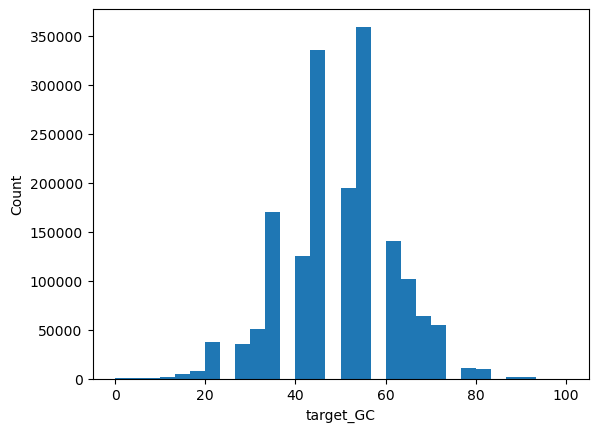

In [22]:
# Calculate and plot the GC contents of the target regions
filters.calc_gc_for_probe_dict(probe_dict, column_key_seq='target_sequence', column_key_write='target_GC')
plot.plot_hist(probe_dict, column_key='target_GC')

Trbc1
	ENSMUST00000192856.6: 513 / 708 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000103291.2: 454 / 483 probes passed the filter 40 < target_GC <  70.
Trbc2
	ENSMUST00000103299.3: 555 / 663 probes passed the filter 40 < target_GC <  70.
Trac
	ENSMUST00000198398.5: 660 / 906 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000103740.2: 325 / 384 probes passed the filter 40 < target_GC <  70.
Trgc1
	ENSMUST00000103558.3: 530 / 895 probes passed the filter 40 < target_GC <  70.
Trgc2
	ENSMUST00000103561.3: 522 / 885 probes passed the filter 40 < target_GC <  70.
Trgc4
	ENSMUST00000179181.3: 513 / 956 probes passed the filter 40 < target_GC <  70.
Csf1r
	ENSMUST00000025523.13: 3430 / 3841 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000235447.2: 624 / 747 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000237706.2: 355 / 387 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000115268.4: 4151 / 4672 probes passed the filter 40 < target_GC <

/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


	ENSMUST00000196398.5: 6125 / 8992 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000198974.2: 287 / 443 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000197118.5: 350 / 394 probes passed the filter 40 < target_GC <  70.
Nav3
	ENSMUST00000032719.15: 7081 / 9933 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000239301.2: 7343 / 10711 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000238286.2: 5666 / 7287 probes passed the filter 40 < target_GC <  70.
Vcan
	ENSMUST00000159910.8: 5114 / 8303 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000159337.8: 1232 / 2244 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000109546.9: 7142 / 12398 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000109543.9: 1698 / 2292 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000109544.9: 3535 / 5673 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000162715.2: 299 / 586 probes passed the filter 40 < target_GC <  70.
	ENSMUST0

	ENSMUST00000199183.5: 1015 / 2314 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000195978.5: 306 / 622 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000199765.2: 349 / 934 probes passed the filter 40 < target_GC <  70.
Fcrla
	ENSMUST00000046322.14: 1150 / 1650 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000159171.2: 1036 / 1342 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000162136.2: 597 / 634 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000162887.2: 413 / 480 probes passed the filter 40 < target_GC <  70.
Cx3cr1
	ENSMUST00000064165.5: 2849 / 3724 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000215016.2: 3515 / 4464 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000177637.2: 2545 / 3127 probes passed the filter 40 < target_GC <  70.
Xylt1
	ENSMUST00000032892.7: 6479 / 8991 probes passed the filter 40 < target_GC <  70.
Fcgr1
	ENSMUST00000029748.8: 2110 / 2560 probes passed the filter 40 < target_GC <  70

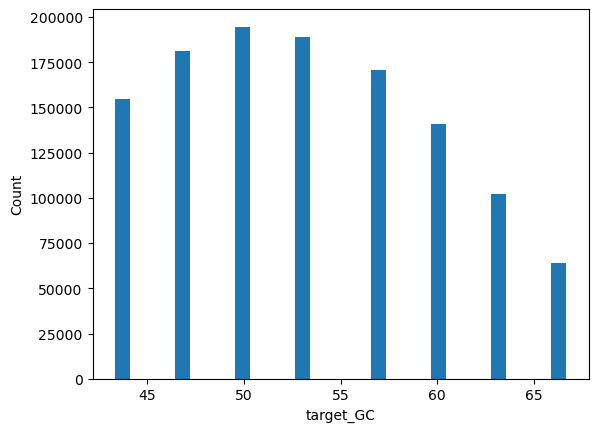

In [23]:
# Filter GC cotent and plot the GC content after filtering
filters.filter_probe_dict_by_metric(probe_dict, 'target_GC', lower_bound=40, upper_bound=70)
plot.plot_hist(probe_dict, column_key='target_GC', bins=30)

### Calculate and filter by probe Tm

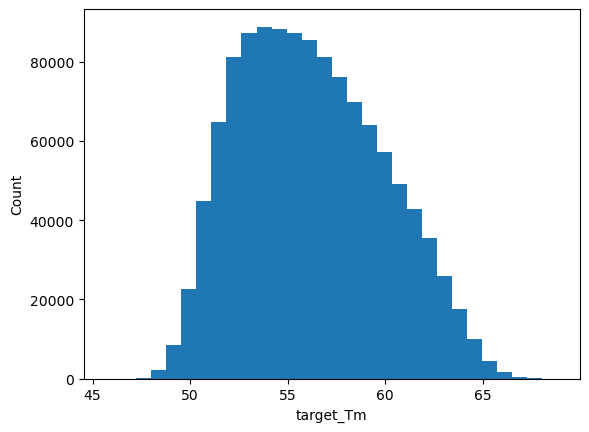

In [24]:
# Calculate and plot the melting-temperatures (Tm)
filters.calc_tm_for_probe_dict(probe_dict, Na_conc=390, fmd_percentile=30, probe_conc=5,
                              column_key_seq='target_sequence', column_key_write='target_Tm')
plot.plot_hist(probe_dict, column_key='target_Tm')

Trbc1
	ENSMUST00000192856.6: 504 / 513 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000103291.2: 453 / 454 probes passed the filter 50 < target_Tm <  65.
Trbc2
	ENSMUST00000103299.3: 548 / 555 probes passed the filter 50 < target_Tm <  65.
Trac
	ENSMUST00000198398.5: 653 / 660 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000103740.2: 321 / 325 probes passed the filter 50 < target_Tm <  65.
Trgc1
	ENSMUST00000103558.3: 503 / 530 probes passed the filter 50 < target_Tm <  65.
Trgc2
	ENSMUST00000103561.3: 501 / 522 probes passed the filter 50 < target_Tm <  65.
Trgc4
	ENSMUST00000179181.3: 497 / 513 probes passed the filter 50 < target_Tm <  65.
Csf1r
	ENSMUST00000025523.13: 3390 / 3430 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000235447.2: 614 / 624 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000237706.2: 351 / 355 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000115268.4: 4096 / 4151 probes passed the filter 50 < target_Tm <

/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


	ENSMUST00000215809.2: 607 / 610 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000214627.2: 375 / 377 probes passed the filter 50 < target_Tm <  65.
Tmtc2
	ENSMUST00000061506.9: 3254 / 3339 probes passed the filter 50 < target_Tm <  65.
Trps1
	ENSMUST00000165201.9: 4584 / 4700 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000184458.8: 2782 / 2850 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000183757.8: 3543 / 3620 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000183997.8: 2637 / 2694 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000184885.8: 2478 / 2533 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000183421.2: 1996 / 2036 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000185183.2: 643 / 661 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000077935.6: 3170 / 3245 probes passed the filter 50 < target_Tm <  65.
Stat3
	ENSMUST00000103114.8: 4685 / 4788 probes passed the filter 50 < target_Tm <  65.
	ENS

	ENSMUST00000187994.7: 716 / 722 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000186526.7: 660 / 665 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000187171.2: 625 / 634 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000190188.2: 286 / 288 probes passed the filter 50 < target_Tm <  65.
Ly6c1
	ENSMUST00000188845.7: 457 / 470 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000065408.16: 643 / 646 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000179762.8: 633 / 639 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000187347.7: 434 / 436 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000191216.7: 347 / 349 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000185200.7: 435 / 446 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000185372.2: 321 / 326 probes passed the filter 50 < target_Tm <  65.
Nxpe4
	ENSMUST00000216998.2: 2773 / 2827 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000215780.2: 21

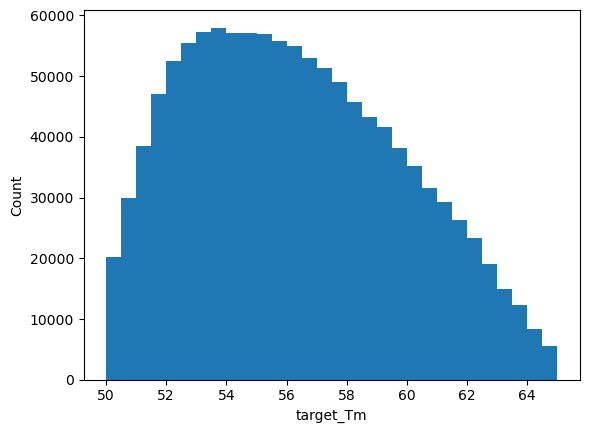

In [25]:
# Filter by Tm
# NOTE: here we used a higher upper bound for GC content and Tm than JM's original
# cutoffs. It was shown that higher Tm gives better signal-to-noise ratios in SM-FISH
filters.filter_probe_dict_by_metric(probe_dict, 'target_Tm', lower_bound=50, upper_bound=65)
plot.plot_hist(probe_dict, column_key='target_Tm')

### Calculate off-targets

In [26]:
# Initialize the off-target counting tables
overwrite_ottable = False
# OTTable for rRNA/tRNAs
if 'ottable_rtRNAs' not in locals() or overwrite_ottable:
    ncRNAs =  fio.load_fasta_into_df(ncRNA_fasta_file)
    ottable_rtRNAs = ot.get_OTTable_for_rtRNAs(ncRNAs, 15)

Found 378 rRNAs/tRNAs from 29245 non-coding RNAs.


In [27]:
# OTTables for the genes we target
if 'gene_ottable_dict' not in locals() or overwrite_ottable:
    #gene_ottable_dict = ot.get_gene_OTTables(transcriptome, sel_isoform_names, 'transcript_id', 17)
    gene_ottable_dict = ot.get_gene_OTTables(transcriptome, gene_ids, 'gene_short_name', 17)

Generate OTTable for gene Igf1r.
Construct a OTTable using 6/6 transcripts with FPKM > 0.
Generate OTTable for gene Trim30b.
Construct a OTTable using 6/6 transcripts with FPKM > 0.
Generate OTTable for gene Itgae.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Lyl1.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Nxpe4.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Il18bp.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Agtrap.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Tbx21.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Xcl1.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Fscn1.
Construct a OTTable using 7/7 transcripts with FPKM > 0.
Generate OTTable for gene Trps1.
Construct a OTTable using 8/8 transcripts with FPKM > 0.
Generate

Generate OTTable for gene Pglyrp1.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Nav3.
Construct a OTTable using 8/8 transcripts with FPKM > 0.
Generate OTTable for gene Il2.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Ifng.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Stat3.
Construct a OTTable using 14/14 transcripts with FPKM > 0.
Generate OTTable for gene Itga2.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Ms4a1.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Tigit.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Tcf7.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Prf1.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Trgc2.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTT

Generate OTTable for gene Il1a.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Adgrg6.
Construct a OTTable using 5/5 transcripts with FPKM > 0.
Generate OTTable for gene Gsto1.
Construct a OTTable using 6/6 transcripts with FPKM > 0.
Generate OTTable for gene Gata3.
Construct a OTTable using 6/6 transcripts with FPKM > 0.


In [28]:
# OTTable for the transcriptome.
if 'ottable_transcriptome' not in locals() or overwrite_ottable:
    ottable_transcriptome = ot.get_OTTable_for_transcriptome(transcriptome, 17)

Construct a OTTable using 116912/116912 transcripts with FPKM > 0.
Processed 10000/116912 sequences.
Processed 20000/116912 sequences.
Processed 30000/116912 sequences.
Processed 40000/116912 sequences.
Processed 50000/116912 sequences.
Processed 60000/116912 sequences.
Processed 70000/116912 sequences.
Processed 80000/116912 sequences.
Processed 90000/116912 sequences.
Processed 100000/116912 sequences.
Processed 110000/116912 sequences.


In [29]:
# Calculate and plot the off-targets to rRNA/tRNAs
ot.calc_OTs(probe_dict, ottable_rtRNAs, 'target_sequence', 'target_OT_rtRNA', 15)
#plot.plot_hist(probe_dict, 'target_OT_rtRNA', y_max=400)
# Filter out probes that have any rRNA/tRNA off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_OT_rtRNA', upper_bound=0.5)
#plot.plot_hist(probe_dict, 'target_OT_rtRNA')

Calculate OTs for 0/205 genes.
Calculate OTs for 1/205 genes.
Calculate OTs for 2/205 genes.
Calculate OTs for 3/205 genes.
Calculate OTs for 4/205 genes.
Calculate OTs for 5/205 genes.
Calculate OTs for 6/205 genes.
Calculate OTs for 7/205 genes.
Calculate OTs for 8/205 genes.
Calculate OTs for 9/205 genes.
Calculate OTs for 10/205 genes.
Calculate OTs for 11/205 genes.
Calculate OTs for 12/205 genes.
Calculate OTs for 13/205 genes.
Calculate OTs for 14/205 genes.
Calculate OTs for 15/205 genes.
Calculate OTs for 16/205 genes.
Calculate OTs for 17/205 genes.
Calculate OTs for 18/205 genes.
Calculate OTs for 19/205 genes.
Calculate OTs for 20/205 genes.
Calculate OTs for 21/205 genes.
Calculate OTs for 22/205 genes.
Calculate OTs for 23/205 genes.
Calculate OTs for 24/205 genes.
Calculate OTs for 25/205 genes.
Calculate OTs for 26/205 genes.
Calculate OTs for 27/205 genes.
Calculate OTs for 28/205 genes.
Calculate OTs for 29/205 genes.
Calculate OTs for 30/205 genes.
Calculate OTs for 

/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


	ENSMUST00000198398.5: 653 / 653 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000103740.2: 321 / 321 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Trgc1
	ENSMUST00000103558.3: 503 / 503 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Trgc2
	ENSMUST00000103561.3: 501 / 501 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Trgc4
	ENSMUST00000179181.3: 497 / 497 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Csf1r
	ENSMUST00000025523.13: 3390 / 3390 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000235447.2: 578 / 614 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000237706.2: 351 / 351 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000115268.4: 4096 / 4096 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Tigit
	ENSMUST00000096065.6: 702 / 703 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Lyz1
	ENSMUST00000092162.7: 916 / 917 probes passed the filter -inf < targe

	ENSMUST00000184458.8: 2782 / 2782 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000183757.8: 3543 / 3543 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000183997.8: 2637 / 2637 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000184885.8: 2478 / 2478 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000183421.2: 1996 / 1996 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000185183.2: 643 / 643 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000077935.6: 3170 / 3170 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Stat3
	ENSMUST00000103114.8: 4685 / 4685 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000127638.8: 3432 / 3432 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000092671.12: 2237 / 2237 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000138438.2: 1945 / 1945 probes passed the filter -inf < target_OT_rtRNA < 

	ENSMUST00000015581.6: 977 / 977 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Ly6a
	ENSMUST00000189068.7: 676 / 676 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000023248.13: 617 / 617 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000187994.7: 716 / 716 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000186526.7: 660 / 660 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000187171.2: 625 / 625 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000190188.2: 286 / 286 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Ly6c1
	ENSMUST00000188845.7: 457 / 457 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000065408.16: 643 / 643 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000179762.8: 633 / 633 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000187347.7: 434 / 434 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST

### Off-targets to transcriptome

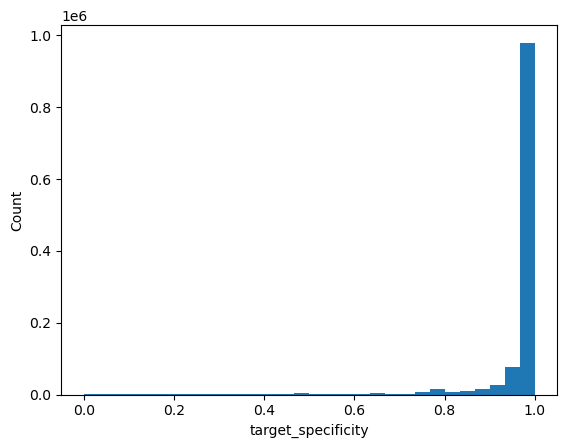

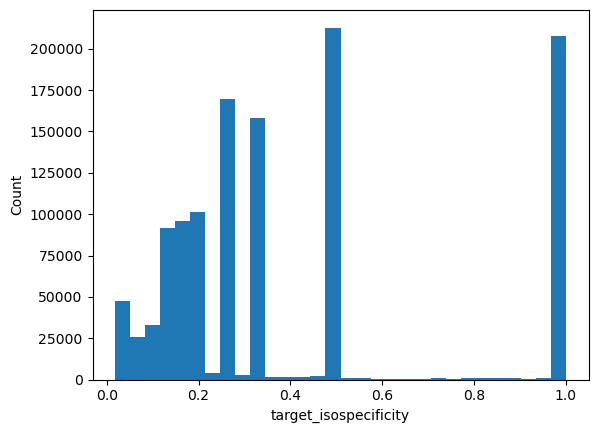

In [30]:
# Get the FPKMs of the transcripts
transcript_fpkms = dict(zip(list(transcriptome['transcript_id']), list(transcriptome['FPKM'])))

# Calculate the specificities and isoform specificities of the target regions
ot.calc_specificity(probe_dict, ottable_transcriptome, gene_ottable_dict, transcript_fpkms,
                    'target_sequence', 'target_specificity', 'target_isospecificity', 17)

plot.plot_hist(probe_dict, 'target_specificity')
plot.plot_hist(probe_dict, 'target_isospecificity')

In [31]:
# modify target isospecificity, if only one isoform exist:
for _gene, _transcript_2_df in probe_dict.items():
    if len(_transcript_2_df) == 1:
        for _transcript, _df in _transcript_2_df.items():
            probe_dict[_gene][_transcript]['target_isospecificity'] = 0.01

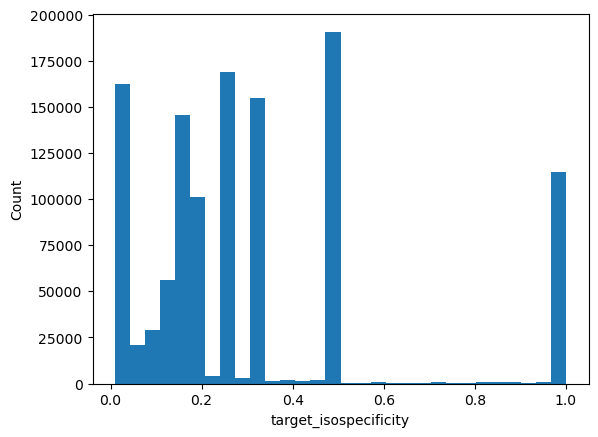

In [32]:
plot.plot_hist(probe_dict, 'target_isospecificity')

Trbc1
	ENSMUST00000192856.6: 148 / 504 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000103291.2: 104 / 453 probes passed the filter 0.99 < target_specificity <  inf.
Trbc2
	ENSMUST00000103299.3: 154 / 548 probes passed the filter 0.99 < target_specificity <  inf.
Trac
	ENSMUST00000198398.5: 536 / 653 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000103740.2: 263 / 321 probes passed the filter 0.99 < target_specificity <  inf.
Trgc1
	ENSMUST00000103558.3: 36 / 503 probes passed the filter 0.99 < target_specificity <  inf.
Trgc2
	ENSMUST00000103561.3: 41 / 501 probes passed the filter 0.99 < target_specificity <  inf.
Trgc4
	ENSMUST00000179181.3: 401 / 497 probes passed the filter 0.99 < target_specificity <  inf.
Csf1r
	ENSMUST00000025523.13: 2679 / 3390 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000235447.2: 472 / 578 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000237706.2: 299 / 351 probe

/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


	ENSMUST00000184458.8: 2420 / 2782 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000183757.8: 3018 / 3543 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000183997.8: 2243 / 2637 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000184885.8: 2104 / 2478 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000183421.2: 1616 / 1996 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000185183.2: 515 / 643 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000077935.6: 2662 / 3170 probes passed the filter 0.99 < target_specificity <  inf.
Stat3
	ENSMUST00000103114.8: 3409 / 4685 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000127638.8: 2591 / 3432 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000092671.12: 1619 / 2237 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000138438.2: 1395 / 1945 probes passed the fi

	ENSMUST00000191216.7: 5 / 347 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000185200.7: 29 / 435 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000185372.2: 34 / 321 probes passed the filter 0.99 < target_specificity <  inf.
Nxpe4
	ENSMUST00000216998.2: 2033 / 2773 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000215780.2: 1465 / 2106 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000093853.5: 1396 / 1952 probes passed the filter 0.99 < target_specificity <  inf.
Csf2
	ENSMUST00000019060.6: 411 / 546 probes passed the filter 0.99 < target_specificity <  inf.
Xcl1
	ENSMUST00000027860.8: 302 / 364 probes passed the filter 0.99 < target_specificity <  inf.
Arhgef10l
	ENSMUST00000069623.12: 2747 / 3486 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000097820.9: 2582 / 3294 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000105799.8: 2659 / 3415 probes passe

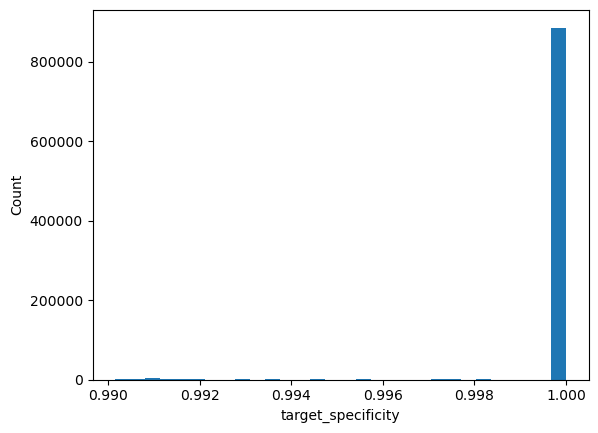

In [33]:
# Filter the specificities of the target regions
# Here we allow the probes to target other isoforms
# Don't allow any gene-level off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_specificity', lower_bound=0.99)
plot.plot_hist(probe_dict, 'target_specificity')

## save probe_dict

In [34]:
import pickle
full_probe_filename = os.path.join(library_folder, 
                                   f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_full_probe_isoforms.pkl")
print(full_probe_filename)
pickle.dump(probe_dict, open(full_probe_filename, 'wb'))

/lab/solexa_weissman/puzheng/MERFISH_Probes/Brain_MS_immune/MF5-EAE_neural_immune/2023_10_27_full_probe_isoforms.pkl


## Restart here

In [37]:
import pickle
full_probe_filename = r'/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary16bit/2023_10_18_full_probe_isoforms.pkl'
if 'probe_dict' not in locals():
    probe_dict = pickle.load(open(full_probe_filename, 'rb'))
replace_dict = np.load(os.path.join(library_folder, 'replace_dict.npy'), allow_pickle=True).item()

## Select probe isoform

In [35]:
# Calculate candidate probe number:
largest_probe_th = 800
median_probe_th = 400


for _gene, _ts_2_pbs in probe_dict.items():
    pb_lens = []
    for _ts, _pbs in _ts_2_pbs.items():
        #print(_ts, len(_pbs))
        pb_lens.append(len(_pbs))
    if len(pb_lens) == 1:
        continue
    # filter
    if np.max(pb_lens) < largest_probe_th and np.median(pb_lens) < median_probe_th:
        print(_gene)
    #break

Trbc1
Trac
Scoc
Ly6g
Alox5ap
Siva1
Itgam
Fam162a
Cd3g
Anapc13
Svbp
Il4
Ly6a
Ly6c1
Klrb1a
Gal3st4
Phospho1
Tnfsf13
Tnfsf12


### Select transcript based on length / number of possible probes:

In [36]:
# Isoform selection
sel_pb_dict = {}
largest_probe_th = 1000
isospecificity_th = 0.5
for _gene, _ts_2_pbs in probe_dict.items():
    # case 1, only one transcript
    if len(_ts_2_pbs) == 1:
        sel_pb_dict[_gene] = _ts_2_pbs
    
    pb_lens = [len(_pbs) for _ts, _pbs in _ts_2_pbs.items()]
    general_pb_lens = [np.sum(_pbs['target_isospecificity'] <= isospecificity_th) 
                       for _ts, _pbs in _ts_2_pbs.items()]
    print(pb_lens, general_pb_lens)
    #break
    # case 2, multiple transcript, now try select nonspecific probes
    # select the transcript with the most common probes
    if np.max(general_pb_lens) > largest_probe_th:
        _t = list(_ts_2_pbs.keys())[general_pb_lens.index(np.max(general_pb_lens))]
        _pbs = _ts_2_pbs[_t]
        sel_pb_dict[_gene] = {_t: _pbs[_pbs['target_isospecificity'] <= largest_probe_th]}
    # case 3: none of transcript has enough common probes: select the one with the most common probes
    elif np.max(pb_lens) > largest_probe_th:
        _t = list(_ts_2_pbs.keys())[general_pb_lens.index(np.max(general_pb_lens))]
        _pbs = _ts_2_pbs[_t]
        sel_pb_dict[_gene] = {_t: _pbs}
    # case 4: all transcripts are short, select teh longest:
    else:
        _t = list(_ts_2_pbs.keys())[pb_lens.index(np.max(pb_lens))]
        _pbs = _ts_2_pbs[_t]
        sel_pb_dict[_gene] = {_t: _pbs}
        
        # check non-specific probes
        _pbs = list(_ts_2_pbs.values())[pb_lens.index(np.max(pb_lens))]
        if np.sum(_pbs['target_isospecificity'] <= isospecificity_th) > largest_probe_th:
            _t = list(_ts_2_pbs.keys())[pb_lens.index(np.max(pb_lens))]
            sel_pb_dict[_gene] = {_t: _pbs[_pbs['target_isospecificity'] <= largest_probe_th]}  
        # select the transcript with the most common probes
    print(_t, len(sel_pb_dict[_gene][_t]))


[148, 104] [94, 94]
ENSMUST00000192856.6 148
[154] [154]
ENSMUST00000103299.3 154
[536, 263] [263, 263]
ENSMUST00000198398.5 536
[36] [36]
ENSMUST00000103558.3 36
[41] [41]
ENSMUST00000103561.3 41
[401] [401]
ENSMUST00000179181.3 401
[2679, 472, 299, 3263] [2651, 458, 291, 2576]
ENSMUST00000025523.13 2679
[469] [469]
ENSMUST00000096065.6 469
[177] [177]
ENSMUST00000092162.7 177
[677, 667] [638, 593]
ENSMUST00000024791.15 677
[1096] [1096]
ENSMUST00000021674.7 1096
[269, 192, 2631, 2981, 1176, 3314, 112, 2167] [262, 79, 2591, 2938, 1164, 3301, 97, 2110]
ENSMUST00000173246.8 3314
[1274, 672] [548, 548]
ENSMUST00000043301.14 1274
[2222] [2222]
ENSMUST00000030865.9 2222
[38] [38]
ENSMUST00000096691.5 38
[524] [524]
ENSMUST00000068592.5 524
[323, 2278, 1378, 1934, 1236, 4543] [207, 2271, 1242, 1934, 1236, 2320]
ENSMUST00000171588.2 4543
[1959, 155, 198, 161, 1163] [854, 76, 150, 67, 797]
ENSMUST00000116456.10 1959
[58, 290, 252, 124, 31, 66] [58, 290, 250, 103, 31, 24]
ENSMUST00000081506.11

ENSMUST00000046864.14 2080
[1371, 757, 720, 667, 661, 636, 614] [833, 707, 718, 652, 661, 626, 608]
ENSMUST00000005678.6 1371
[746] [746]
ENSMUST00000003469.8 746
[968, 824] [849, 811]
ENSMUST00000106162.8 968
[1088] [1088]
ENSMUST00000036572.4 1088
[1927, 211, 550, 289, 1908] [1924, 211, 550, 271, 1908]
ENSMUST00000086763.13 1927
[729, 721] [646, 646]
ENSMUST00000029345.12 729
[1293, 1479, 1011] [1215, 1278, 872]
ENSMUST00000197040.5 1479
[1102] [1102]
ENSMUST00000015157.10 1102
[4372, 2159, 4237] [4363, 2138, 4237]
ENSMUST00000108180.9 4372
[1358, 1514, 593] [1256, 1256, 437]
ENSMUST00000111763.8 1358
[1404] [1404]
ENSMUST00000027507.9 1404
[715] [715]
ENSMUST00000029626.9 715
[538, 761] [538, 761]
ENSMUST00000118006.3 761
[362, 887, 278, 312] [332, 332, 269, 272]
ENSMUST00000199183.5 887
[908, 837, 441, 327] [826, 820, 429, 305]
ENSMUST00000046322.14 908
[1986, 2498, 1892] [1986, 1986, 1892]
ENSMUST00000064165.5 1986
[4878] [4878]
ENSMUST00000032892.7 4878
[1628] [1628]
ENSMUST00000

In [37]:
p_d.print_probe_dict(sel_pb_dict) 
# We excluded all the transcripts that are not our direct targets

Gene	Transcript	N_probes
Trbc1
	ENSMUST00000192856.6	148
Trbc2
	ENSMUST00000103299.3	154
Trac
	ENSMUST00000198398.5	536
Trgc1
	ENSMUST00000103558.3	36
Trgc2
	ENSMUST00000103561.3	41
Trgc4
	ENSMUST00000179181.3	401
Csf1r
	ENSMUST00000025523.13	2679
Tigit
	ENSMUST00000096065.6	469
Lyz1
	ENSMUST00000092162.7	177
Trem2
	ENSMUST00000024791.15	677
Fos
	ENSMUST00000021674.7	1096
Jarid2
	ENSMUST00000173246.8	3314
Aicda
	ENSMUST00000043301.14	1274
Agtrap
	ENSMUST00000030865.9	2222
Il22
	ENSMUST00000096691.5	38
Ifng
	ENSMUST00000068592.5	524
Lifr
	ENSMUST00000171588.2	4543
Cyth3
	ENSMUST00000116456.10	1959
Scoc
	ENSMUST00000081506.11	290
Clec4d
	ENSMUST00000032240.4	418
Cd8a
	ENSMUST00000066747.14	1528
Cd19
	ENSMUST00000206325.2	1639
Il7r
	ENSMUST00000228782.2	1135
Nkg7
	ENSMUST00000070518.4	502
Dram1
	ENSMUST00000020249.2	1529
Pou2af1
	ENSMUST00000034554.9	1166
Cd274
	ENSMUST00000016640.8	1693
Siglece
	ENSMUST00000032667.10	1106
Il33
	ENSMUST00000120388.9	1119
Lamp1
	ENSMUST00000033824.8	1130
L

In [38]:
sequencing_data_folder = r'/lab/solexa_weissman/kyost/pe_lineage/230427_4T1_10X'
manual_kept_genes = pd.read_csv(os.path.join(sequencing_data_folder, 'merfish_4T1_genes_removed.csv'))

In [39]:
kept_gene_list = []
removed_gene_list = []
for _gene, _t_2_pbs in sel_pb_dict.items():
    _pbs = list(_t_2_pbs.values())[0]
    if len(_pbs) < 600 and _gene not in list(manual_kept_genes['gene']):
        print(_gene)
        removed_gene_list.append(_gene)
    else:
        kept_gene_list.append(_gene)

Trbc1
Trbc2
Trac
Trgc1
Trgc2
Trgc4
Tigit
Lyz1
Il22
Scoc
Clec4d
Nkg7
Il27
Il2
Gimap1
Gimap5
Pglyrp1
Il17a
Il17f
Cd55
Siva1
Itgam
Fam162a
Anapc13
Svbp
Icos
Ly6a
Ly6c1
Csf2
Xcl1
Cyp4f16
Klrb1a
Mrpl54
Ifi211
Gal3st4
Phospho1
Tnfsf13
Tnfsf12


In [40]:
len(kept_gene_list)

167

In [46]:
# given these genes, re-calculate expression
target_gene_umi_frac_filename = os.path.join(library_folder, 'marker_gene_umi_frac.csv')
target_gene_umi_frac_df = pd.read_csv(target_gene_umi_frac_filename)
target_gene_umi_frac_df = target_gene_umi_frac_df.set_index(target_gene_umi_frac_df.columns[0])
target_gene_umi_frac_df.rename(index=replace_dict, inplace=True)
kept_gene_umi_frac_df = target_gene_umi_frac_df.loc[np.array(kept_gene_list)]


In [47]:
figure_folder = os.path.join(library_folder, 'figures')
if not os.path.exists(figure_folder):
    os.makedirs(figure_folder)

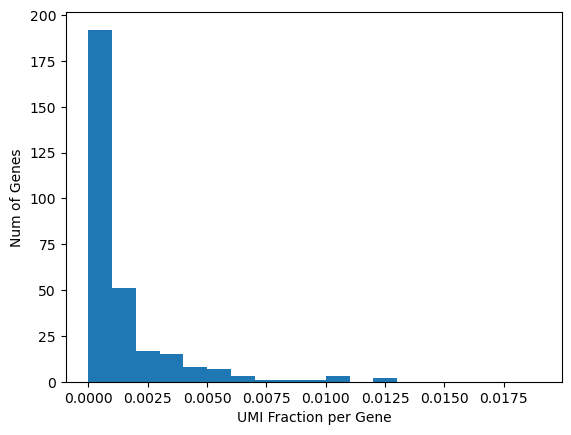

In [48]:
plt.figure()
plt.hist(np.sum(kept_gene_umi_frac_df, 1), bins=np.arange(0, 0.02, 0.001))
plt.xlabel("UMI Fraction per Gene")
plt.ylabel("Num of Genes")
plt.savefig(os.path.join(figure_folder, 
                         f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_UMI_fraction_histogram.png"), 
            transparent=True)
plt.show()

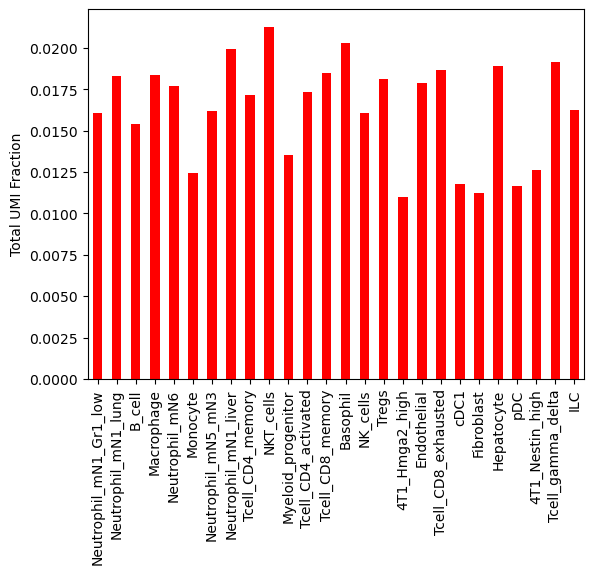

In [49]:
plt.figure()
np.sum(kept_gene_umi_frac_df, 0).plot.bar(color='red')
plt.ylabel("Total UMI Fraction")
plt.savefig(os.path.join(figure_folder, 
                         f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_Total_UMI_fraction.png"), 
            transparent=True)
plt.show()

In [50]:
len(kept_gene_list)

301

## determine marker gene group

In [51]:
group_2_genes = {_g:[] for _g in target_gene_mean_exp_df.columns}
for _gene in kept_gene_list:
    _exp = target_gene_mean_exp_df.loc[_gene]
    _group = _exp.index[np.argmax(_exp)]
    group_2_genes[_group].append(_gene)
marker_gene_num_df = pd.Series({_group: len(_genes) for _group, _genes in group_2_genes.items()})

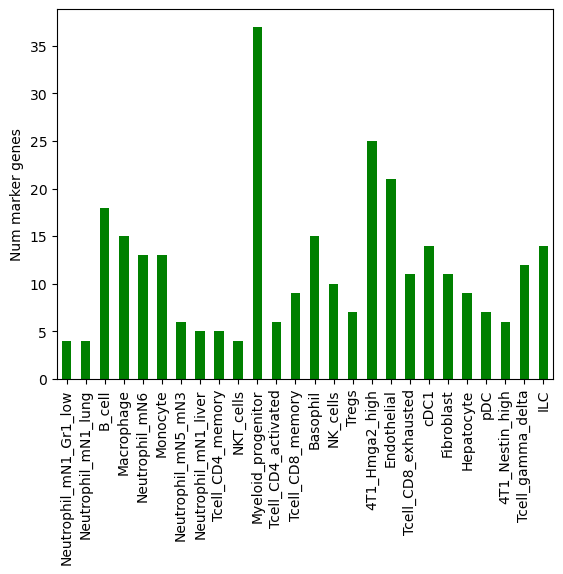

In [52]:
plt.figure()
marker_gene_num_df.plot.bar(color='green')
plt.ylabel("Num marker genes")
plt.savefig(os.path.join(figure_folder, 
                         f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_marker_gene_number.png"), 
            transparent=True)
plt.show()

In [53]:
gene_2_group = {}
for _group, _genes in group_2_genes.items():
    for _g in _genes:
        gene_2_group[_g] = _group

In [54]:
# candidate probes
candidate_probe_filename = os.path.join(library_folder, 
                                   f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_candidate_probe.pkl")
print(candidate_probe_filename)
pickle.dump(sel_pb_dict, open(candidate_probe_filename, 'wb'))

/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary22bit/2023_10_19_candidate_probe.pkl


In [55]:
# load probe_dict
probe_dict = pickle.load(open(full_probe_filename, 'rb'))

In [56]:
# delete
del(probe_dict)

In [57]:
# Save the list of genes
kept_gene_filename = os.path.join(library_folder, 'kept_gene_info.csv')

kept_gene_info = ({'Name':kept_gene_list,
                   'Transcript': [list(sel_pb_dict[_gene].keys())[0] for _gene in kept_gene_list],
                   'Num_Candidate_Probes': [len(list(sel_pb_dict[_g].values())[0]) for _g in kept_gene_list],
                  'Group': [gene_2_group[_g] for _g in kept_gene_list],
                  }
                 )
                    
kept_gene_info = pd.DataFrame(kept_gene_info).set_index("Name")
# add info
kept_gene_info = pd.concat([kept_gene_info, target_gene_mean_exp_df.loc[kept_gene_list]], axis=1)
# save
kept_gene_info.to_csv(kept_gene_filename, index=1)
print(kept_gene_filename)

/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary22bit/kept_gene_info.csv


In [58]:
kept_gene_info

,Transcript,Num_Candidate_Probes,Group,Neutrophil_mN1_Gr1_low,Neutrophil_mN1_lung,B_cell,Macrophage,Neutrophil_mN6,Monocyte,Neutrophil_mN5_mN3,...,4T1_Hmga2_high,Endothelial,Tcell_CD8_exhausted,cDC1,Fibroblast,Hepatocyte,pDC,4T1_Nestin_high,Tcell_gamma_delta,ILC
Trdc,ENSMUST00000196323.2,2097,Tcell_gamma_delta,0.001265,0.000746,0.005766,0.003817,0.001539,0.000579,0.000000,...,0.000950,0.015243,0.007407,0.002408,0.010699,0.000000,0.000000,0.000000,1.242275,0.065402
Ighd,ENSMUST00000194162.6,946,B_cell,0.005038,0.002149,0.899805,0.006848,0.003647,0.003574,0.000431,...,0.000000,0.011424,0.000000,0.009489,0.000000,0.014535,0.039486,0.000000,0.000000,0.000000
Gramd3,ENSMUST00000237355.2,1354,Tcell_CD8_memory,0.014021,0.018353,0.833495,0.067402,0.024259,0.075371,0.006781,...,0.149769,0.184072,1.408295,0.206109,0.124862,0.128767,0.161856,0.008005,0.552079,0.028583
Klhl14,ENSMUST00000122333.2,2032,B_cell,0.001232,0.001544,0.349993,0.002983,0.001354,0.001788,0.000830,...,0.000000,0.000000,0.004909,0.004353,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Tmem252,ENSMUST00000057243.6,2293,Endothelial,0.000183,0.000112,0.000000,0.000000,0.000000,0.000576,0.000581,...,0.000000,0.359993,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Azgp1,ENSMUST00000035390.7,825,Hepatocyte,0.000842,0.000000,0.000423,0.000000,0.000705,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.959204,0.013355,0.000000,0.000000,0.000000
Pms2,ENSMUST00000148011.8,2980,NK_cells,0.009502,0.006433,0.085660,0.021158,0.055663,0.033777,0.006720,...,0.066626,0.060471,0.116089,0.033027,0.035858,0.000000,0.093359,0.002934,0.069166,0.090643
Fzd2,ENSMUST00000057893.7,1376,Fibroblast,0.000000,0.000000,0.000000,0.002899,0.000000,0.000000,0.000000,...,0.143754,0.000000,0.000000,0.003481,0.244014,0.000000,0.000000,0.020520,0.000000,0.000000
Slc24a3,ENSMUST00000110007.8,2169,Basophil,0.011415,0.014678,0.006994,0.067269,0.012917,0.005912,0.068130,...,0.029901,0.067298,0.035639,0.015724,0.110635,0.026548,0.006083,0.008232,0.103887,0.015409


In [59]:
# save removed genes
removed_gene_filename = os.path.join(library_folder, 'removed_genes.csv')
print(removed_gene_filename)
pd.DataFrame({'Name':removed_gene_list}).to_csv(removed_gene_filename, index=None)

/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary22bit/removed_genes.csv


# PAUSE HERE, go to jupyter-3 to design codebook